# Part I - Income and Health. What does the data say?
## by Olubunmi Adejimi

## Introduction
> This is a dataset of the Population growth, fertility, life expectancy and mortality for countries all over the world collected from https://data.un.org/. This data contains the following information:
* `Infant mortality for both sexes (per 1,000 live births)`,
* ` Life expectancy at birth for both sexes (years)`,
* `Life expectancy at birth for females (years)`,
* `Life expectancy at birth for males (years)`,
* `Maternal mortality ratio (deaths per 100,000 population)`,
* `Population annual rate of increase (percent)`,
* `Total fertility rate (children per women)`

> A second dataset from https://databank.worldbank.org/source/world-development-indicators containing the Gross National Income (GNI) per capita for the years 2010, 2015 and 2020, is combined with the previous dataset.

> These data are combined with a `GeoJSON` file collected from https://geojson-maps.ash.ms/, to have a more detailed dataset for a robust analyses.




## Preliminary Wrangling


In [5]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cp = sns.color_palette()
sns.set_context("talk", rc={"axes.labelsize":14})
%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.


In [82]:
#import 1st dataframe
df = pd.read_csv('SYB64_246_202110_Population Growth, Fertility and Mortality Indicators.csv', encoding='latin', header=1)

In [83]:
# select columns of interest and change column names
df = df.iloc[:, 1:5]
df.columns = ['Country', 'Year', 'Series', 'Value']
df['Year'] = df['Year'].astype('str')

In [84]:
df.head(1)

Country  Year  \
0  Total, all countries or areas  2010   

                                         Series Value  
0  Population annual rate of increase (percent)   1.2

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899 entries, 0 to 4898
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  4899 non-null   object
 1   Year     4899 non-null   object
 2   Series   4899 non-null   object
 3   Value    4899 non-null   object
dtypes: object(4)
memory usage: 153.2+ KB


In [86]:
# import GNI dataset
df2 = pd.read_csv("GNI data.csv")

#select necessary columns
df2 = df2[['Country Name', '2010 [YR2010]', '2015 [YR2015]', '2015 [YR2015]']]

#chnage column names
df2.columns = ['country_name', '2010', '2015', '2020']

In [87]:
#Put years as one column
df2 = pd.melt(df2, id_vars=['country_name'], 
             value_vars=['2010', '2015', '2020'])

#rename the columns
df2.columns = ['country_name', 'Year', 'GNI per capita']

In [88]:
#import geojson file and create dataframe from extracted geojson data.
import json
wrld = json.load(open('world.geo.json', 'r'))
subregion = [country['properties']['subregion'] for country in wrld['features']]
name = [country['properties']['sovereignt'] for country in wrld['features']]
economy = [country['properties']['economy'] for country in wrld['features']]
region = [country['properties']['region_wb'] for country in wrld['features']]
continent = [country['properties']['continent'] for country in wrld['features']]


zipped = list(zip(subregion, name, economy, region, continent))   
country_deets = pd.DataFrame(zipped, columns = ['subregion', 'name', 'economy', 'region', 'continent'])
country_deets.head(1)

subregion         name               economy                     region  \
0  Caribbean  The Bahamas  6. Developing region  Latin America & Caribbean   

       continent  
0  North America

In [89]:
## merge dataframes
dff = pd.merge(df, df2, left_on=['Country','Year'], right_on= ['country_name', 'Year'], how='left').dropna()
dff = pd.merge(dff, country_deets, left_on=['Country'], right_on= ['name'], how='left').dropna()
  
# create new dataframe with the features of interest as columns with their corresponding values            
dff = pd.pivot(dff, index=['Country','continent', 'subregion','region', 'economy', 'Year', 'GNI per capita'], 
           columns='Series', values='Value').reset_index()
dff.head(1)

Series      Country continent      subregion      region  \
0       Afghanistan      Asia  Southern Asia  South Asia   

Series                    economy  Year GNI per capita  \
0       7. Least developed region  2010            510   

Series Infant mortality for both sexes (per 1,000 live births)  \
0                                                    72.2        

Series Life expectancy at birth for both sexes (years)  \
0                                                 59.6   

Series Life expectancy at birth for females (years)  \
0                                              61.0   

Series Life expectancy at birth for males (years)  \
0                                            58.3   

Series Maternal mortality ratio (deaths per 100,000 population)  \
0                                                     954         

Series Population annual rate of increase (percent)  \
0                                               2.6   

Series Total fertility rate (children per women)  
0                                            6.5

In [90]:
#clean the GNI per capita column
#replace ".." with null values
dff['GNI per capita'] = dff['GNI per capita'].replace('..', np.NaN)

# change to correct datatype
dff['GNI per capita'] = dff['GNI per capita'].astype('float')

In [91]:
# Clean up the economy column to remain only the necessary strings
dff['economy'] = dff['economy'].str.split('.', expand=True)[1].str.split(':', expand=True)[0].str.replace('region', 'economy')

In [92]:

#replace the thousand separator for easy converrsion to numerical data type
dff['Maternal mortality ratio (deaths per 100,000 population)'] = dff['Maternal mortality ratio (deaths per 100,000 population)'].str.replace(',', '')

In [93]:
# convert numerical columns from strings to float

for col in dff[['Infant mortality for both sexes (per 1,000 live births)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for females (years)',
       'Life expectancy at birth for males (years)',
       'Maternal mortality ratio (deaths per 100,000 population)',
       'Population annual rate of increase (percent)',
       'Total fertility rate (children per women)']]:
       if dff[col].dtype == 'object':
              dff[col] = dff[[col]].astype('float')

In [94]:
# replace null values with the median for each country. 
# Median is used because the distribution for feature is skewed.

dff['Maternal mortality ratio (deaths per 100,000 population)'] = dff['Maternal mortality ratio (deaths per 100,000 population)'].fillna(dff.groupby(
            ['Country'])['Maternal mortality ratio (deaths per 100,000 population)'].transform('median'))

In [95]:
# create new columns with income levels based on article (link below) from 2020
# https://www.weforum.org/agenda/2020/08/world-bank-2020-classifications-low-high-income-countries/

dff['Income level'] = ['High income' if x > 12535 else 'Low income' if x < 1036 else 'Lower-middle income' if 
1036<=x<=4045 else 'Upper-middle income' for x in dff['GNI per capita']]

In [96]:
# check the shape of the dataframe
dff.shape

(420, 15)

In [97]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 15 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Country                                                   420 non-null    object 
 1   continent                                                 420 non-null    object 
 2   subregion                                                 420 non-null    object 
 3   region                                                    420 non-null    object 
 4   economy                                                   420 non-null    object 
 5   Year                                                      420 non-null    object 
 6   GNI per capita                                            415 non-null    float64
 7   Infant mortality for both sexes (per 1,000 live births)   420 non-null    float64
 8   Life expectancy at b

In [98]:
# export cleaned dataframe
dff.to_csv('pop_mort.csv')

### What is the structure of your dataset?

> The datset has 447 rows and 13 columns.

### What is/are the main feature(s) of interest in your dataset?

> The main features of interest in the dataset are:
* `Infant mortality for both sexes (per 1,000 live births)`,
* `Life expectancy at birth for both sexes (years)`,
* `Life expectancy at birth for females (years)`,
* `Life expectancy at birth for males (years)`,
* `Maternal mortality ratio (deaths per 100,000 population)`,
* `Population annual rate of increase (percent)`,
* `Total fertility rate (children per women)`
* `GNI per capita`

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> These fetaures; `Country`, `continent`, `region`, `subregion`, `economy`, 'Income level`, and `Year` will support my investigation.


## Univariate Exploration


In [99]:
cols = ['Infant mortality for both sexes (per 1,000 live births)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for females (years)',
       'Life expectancy at birth for males (years)',
       'Maternal mortality ratio (deaths per 100,000 population)',
       'Population annual rate of increase (percent)',
       'Total fertility rate (children per women)',
       'GNI per capita']

In [100]:
'''
A function for creating distribution plot using Seaborns histplot.
'''

def dist_plot(df, x, **kwargs):
    plt.figure(figsize=(10, 8))
    sns.histplot(df[x], bins=bin_s, kde=True);
    plt.box(False)

> Q: What is the distribution of infant mortality

In [101]:
bin_s = np.arange(0, dff[cols[0]].max()+1.2, 1.2)

dist_plot(dff, cols[0])

* O: Infant mortality is predomiantly low for most countries.

> Q: What is the distribution of maternal mortality

In [102]:
bin_s = np.arange(0, dff[cols[4]].max()+14, 14)

dist_plot(dff, cols[4])

* O: Maternal mortality is predomiantly low for most countries.

> Q: What is the most probable life expectancy of countries?

In [103]:
bin_s = np.arange(0, dff[cols[1]].max()+2, 2)

dist_plot(dff, cols[1])

* O: Life expectancy is predomiantly low for most countries.

> Q: What is the most probable rate of annual population increase?

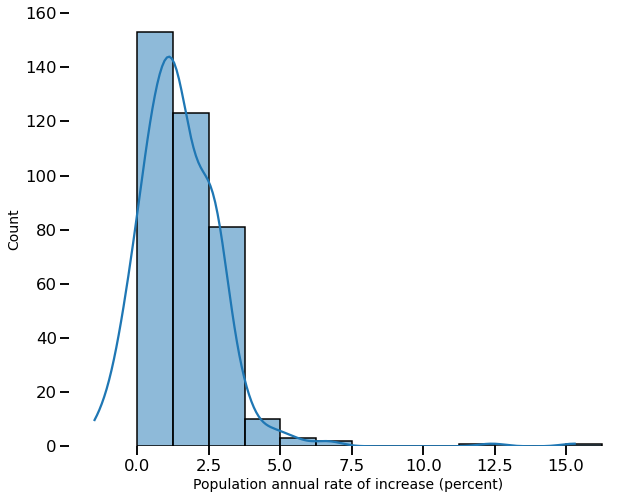

In [104]:
bin_s = np.arange(0, dff[cols[-3]].max()+1.25, 1.25)

dist_plot(dff, cols[-3])

* O: The rate of population increase is predomiantly low for most countries.

In [105]:
dff[dff['Population annual rate of increase (percent)'] >= 10]

Series               Country continent     subregion  \
321                    Qatar      Asia  Western Asia   
396     United Arab Emirates      Asia  Western Asia   

Series                      region              economy  Year  GNI per capita  \
321     Middle East & North Africa   Developing economy  2010         63620.0   
396     Middle East & North Africa   Developing economy  2010         33400.0   

Series  Infant mortality for both sexes (per 1,000 live births)  \
321                                                   8.3         
396                                                   7.7         

Series  Life expectancy at birth for both sexes (years)  \
321                                                78.7   
396                                                75.9   

Series  Life expectancy at birth for females (years)  \
321                                             80.3   
396                                             77.3   

Series  Life expectancy at birth for males (years)  \
321                                           77.6   
396                                           75.1   

Series  Maternal mortality ratio (deaths per 100,000 population)  \
321                                                  10.0          
396                                                   4.0          

Series  Population annual rate of increase (percent)  \
321                                             15.3   
396                                             12.4   

Series  Total fertility rate (children per women) Income level  
321                                           2.2  High income  
396                                           2.0  High income


* O: The data for the features of interest are skewed, meaning the distribution is not normal. For example, the distribution of the `Population annual rate of increase (percent)` shows that more countries are growing at a slower rate. Upon further investigation, it is revealed that only Qatar and the United Arab Emirates have a population growing at a rate greater than 10%. The `Life expectancy at birth for both sexes (years)` is negatively skewed showing that most countries of the world have high life expectancies.


* O: The dataframe was tidied to make each feature into a column, missing data was replace for the `Maternal mortality ratio (deaths per 100,000 population)` column with the median for each country. Median is used because the data is skewed and mean is affected by outliers.

> Q: What is the most probable GNI per capita in USD for people to earn globally

In [72]:
bin_s = np.arange(0, dff[cols[7]].max()+1000, 1000)

dist_plot(dff, cols[7])

* O: Over 60 countries in the worl d have an annual GNI per capitta < 1, 000 USD, i.e. most people in the world are probably going to earn no more than 1,000 USD anually.

> Q: How many countries belong to the different each income level?

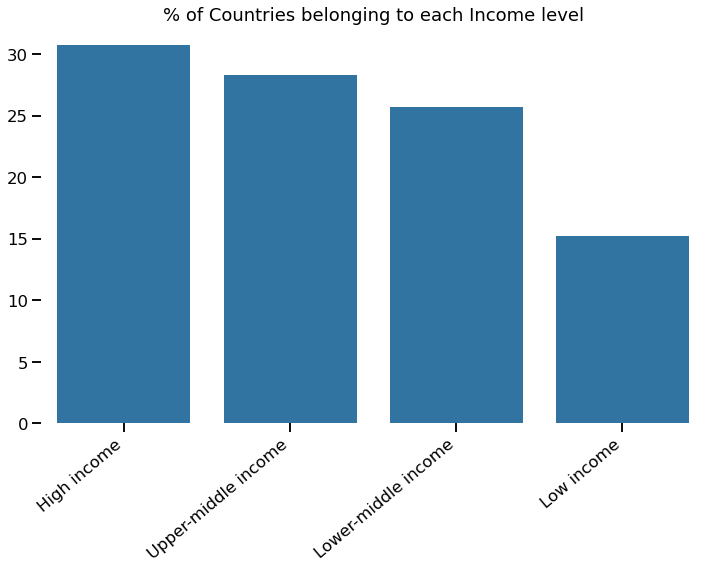

In [107]:
y = (dff['Income level'].value_counts()/dff['Income level'].value_counts().sum())*100


plt.figure(figsize=(10, 8))
sns.barplot(x=y.index, y=y.values, color=cp[0])
plt.xticks(rotation=40, ha='right');
plt.title('% of Countries belonging to each Income level')
plt.box(False)


plt.tight_layout();

* O: Most countries are categorizeed as developing economies and the least number of countries are considered emerging economies.

## Bivariate Exploration

In [253]:
# define function for making rigdgeplots for variables
def ridge_plot(df, row, cols):
    for col in cols:
        plt.figure(figsize=(15, 12))
        g = sns.FacetGrid(df, row=row, hue=row, aspect=10, height=.7, palette='PuBuGn');
        g.map(sns.kdeplot, col, 
                        fill=True, bw_adjust=.3, clip_on=False, alpha=1);
            #plt.xlim(-0.1, 10000000)
        g.set_titles("")
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)
        g.figure.subplots_adjust(hspace=-.45)
        g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)
        #plt.xlim(df[col].min(), df[col].quantile(.75))

        def label(x, color, label):
                ax = plt.gca()
                ax.text(1, .5, label, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes)


        g.map(label, col)

> Q: What is the distribution of variables of interest in each continent

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

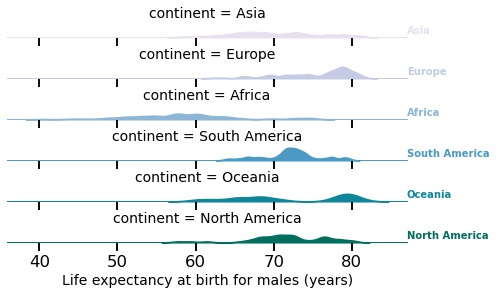

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

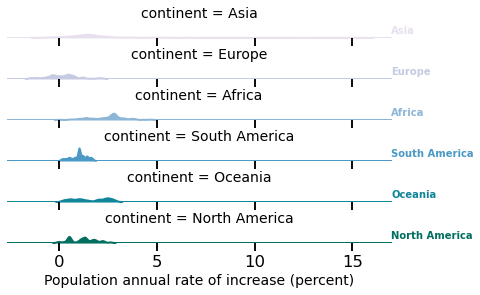

<Figure size 1080x864 with 0 Axes>

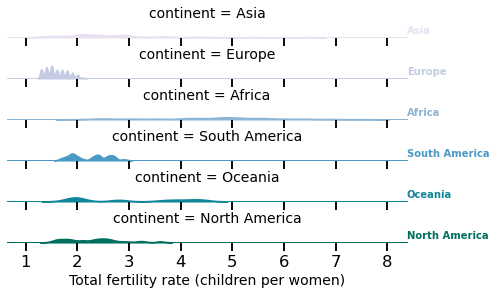

<Figure size 1080x864 with 0 Axes>

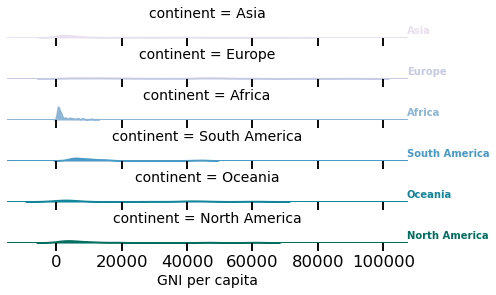

In [254]:
# distribution plots of the variables by the continents
ridge_plot(dff, 'continent', cols)

* O: The rate of population increase is highest for African countries and Europe has the lowest rate of population increase.
* O: Africa and Asia have the lowest GNI per capita. African countries have more countries in the lower mean GNI per capita.
* O: Fertility rate is has a high standard deviation for African countries, and the lowst standard deviation and fertility rate are observed in Europe.

In [162]:
'''
A function for making pointplots that takes the dataframe and column name as arguments.
'''
def point_plot(df, x, x_order=None):
    x_order = df[x].unique()
    x_order.sort()
    for col in cols:
        plt.figure(figsize=(12, 8))
        sns.pointplot(x=x, y=col, data=df, order=x_order);
        plt.xlabel('')
        plt.box(False)

> Q: How have the variables of interest changed globally over 10 years?

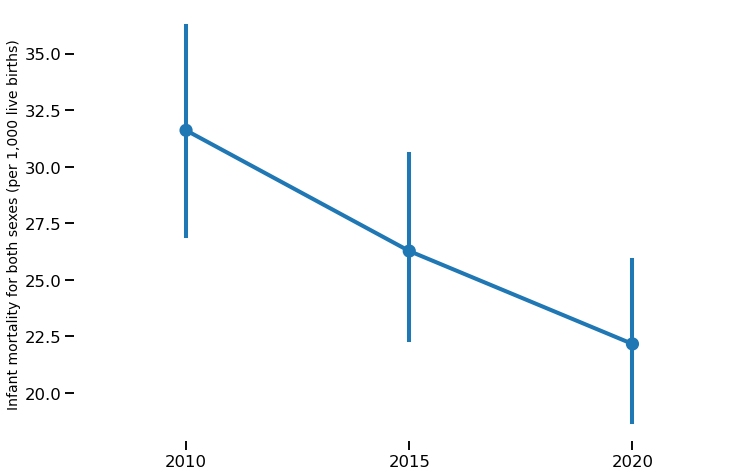

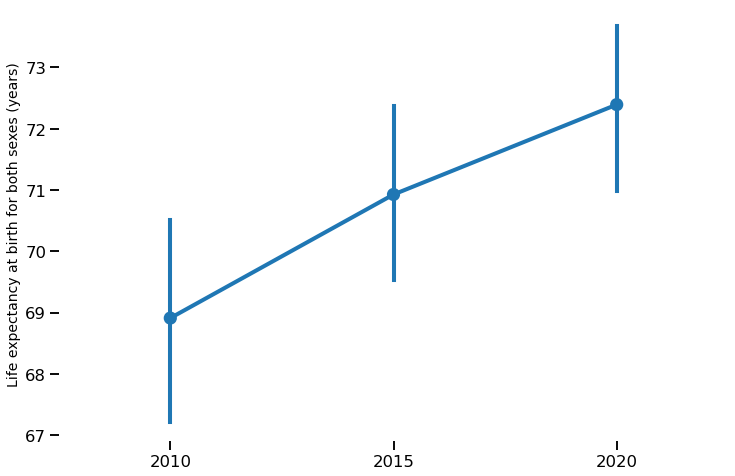

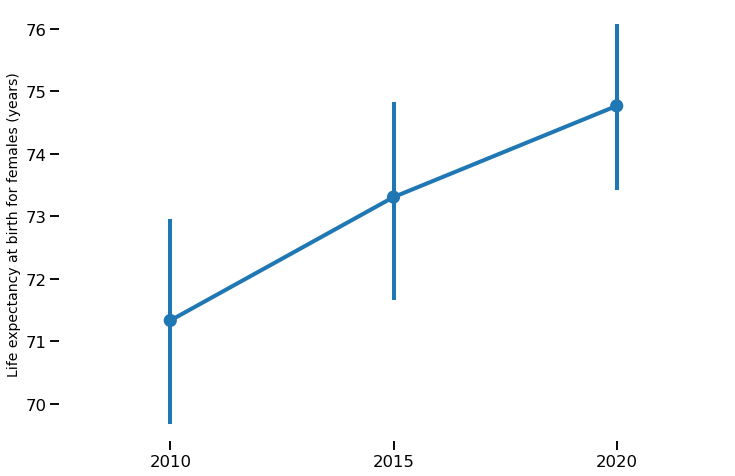

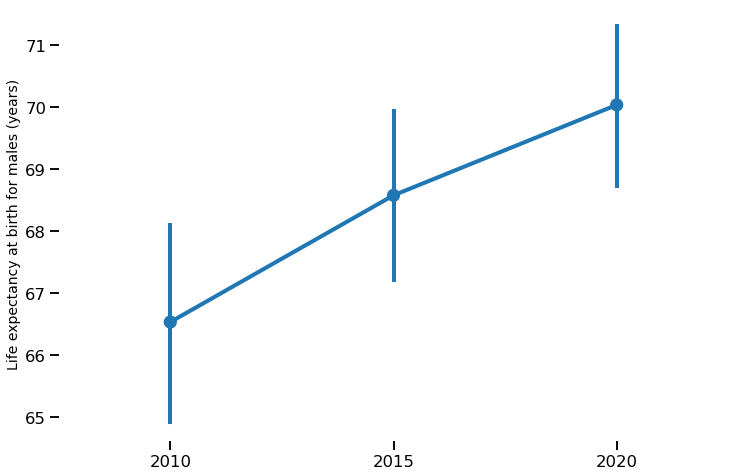

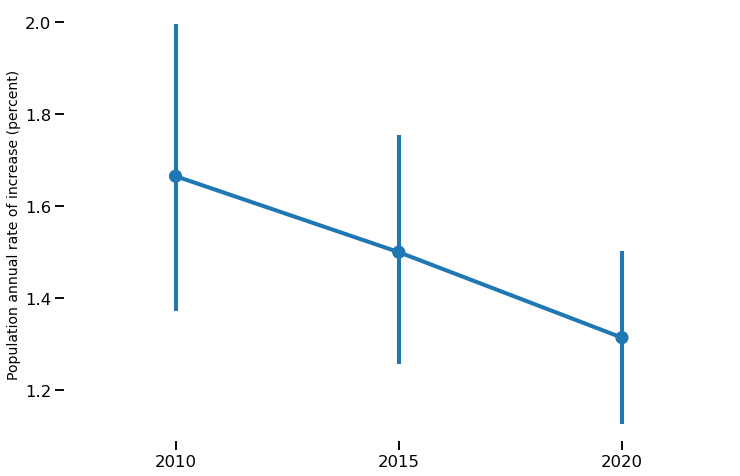

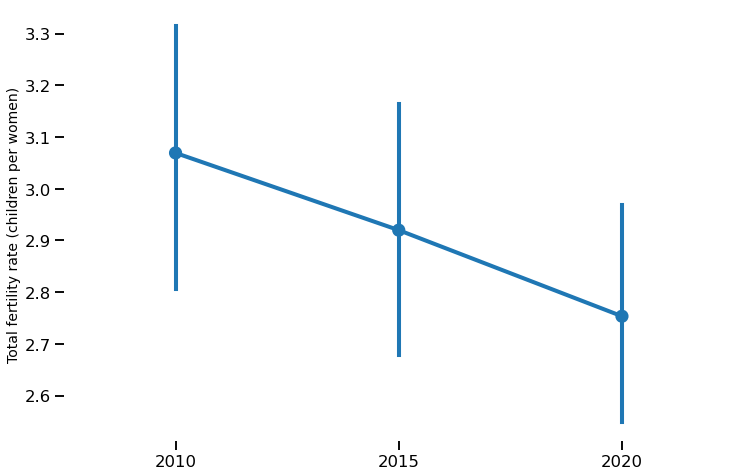

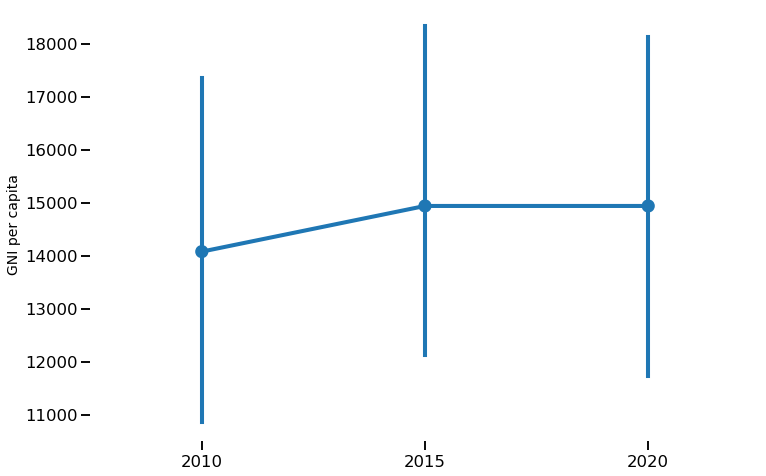

In [163]:
point_plot(dff, 'Year')

* O: Life expectancy globally has increased from 69 years to > 72 years.
* O: Infant mortality, globally, has decreased from ~ 32 infants/1000 to ~ 22.5 infants/1000, an almost 10 point improvement.
* O: Fertility rate, globally, has decreased from about 3 children/woman to 2.75 children/women.

> Q: Is there a difference in variables for different continents?

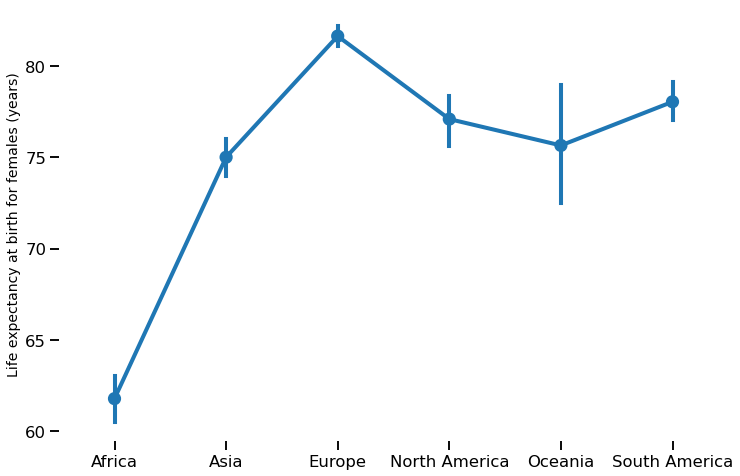

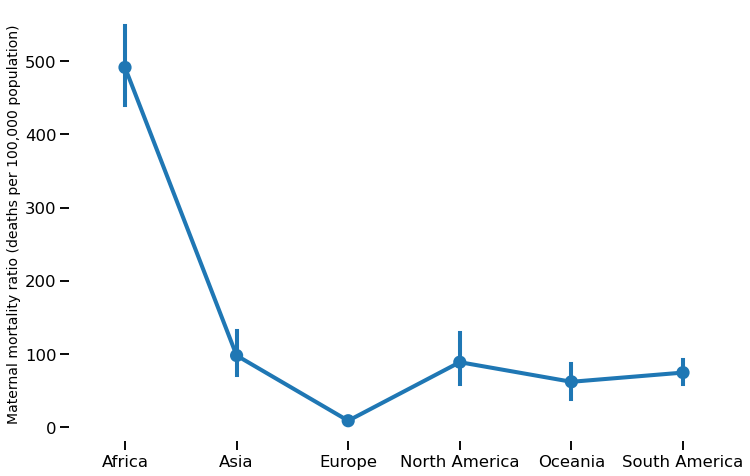

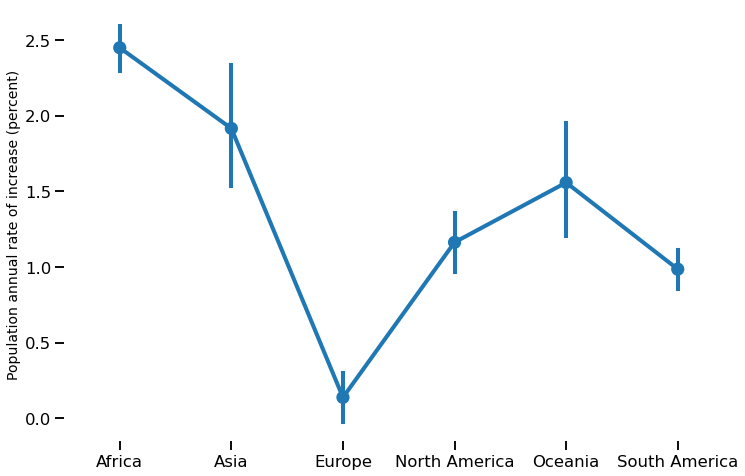

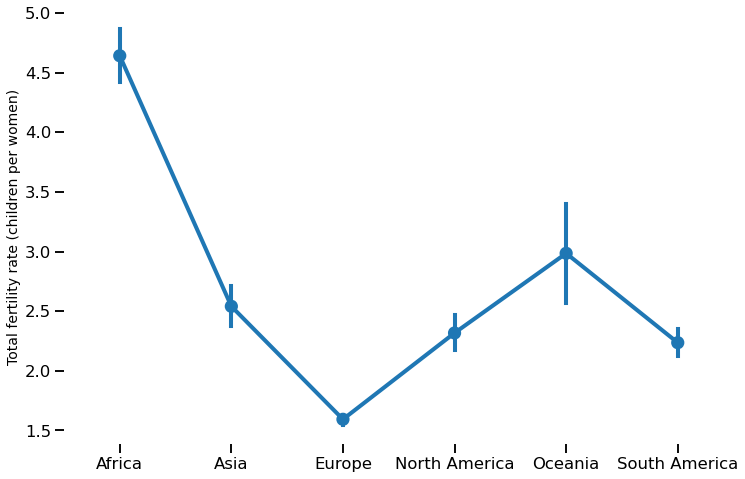

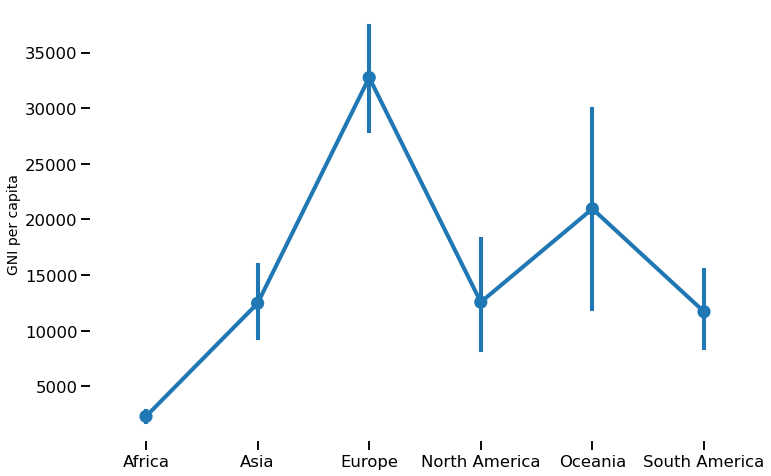

In [164]:
point_plot(dff, 'continent')

* O: Infant mortality rate is different across different continents, reaching 55 infants/1000 in Africa and as low as about 5 infants/1000 in Europe.
* O: Yes. Africa has 3 times as high fertilty rate as Europe and Oceania has the 2nd hightest fertility rate.
* O: Europe had the highest average GNI per capita, Africa has the lowest.
* O: The average maternal mortality rate in Africa is five times as high as any other continent.

In [215]:
def bars(df, x, hue, title, p=None):
    plt.figure(figsize=(10, 8))
    plt.box()
    sns.countplot(x=x, data=df,  order = df[x].value_counts().index, hue=hue, palette=p);
    plt.xticks(rotation=40, ha='right');
    plt.ylabel('')
    plt.xlabel('')
    plt.title(title)
    plt.tight_layout();
    plt.legend(bbox_to_anchor=(1, 1))

> Q: Has the number of countries changed in each income level over a deccade?

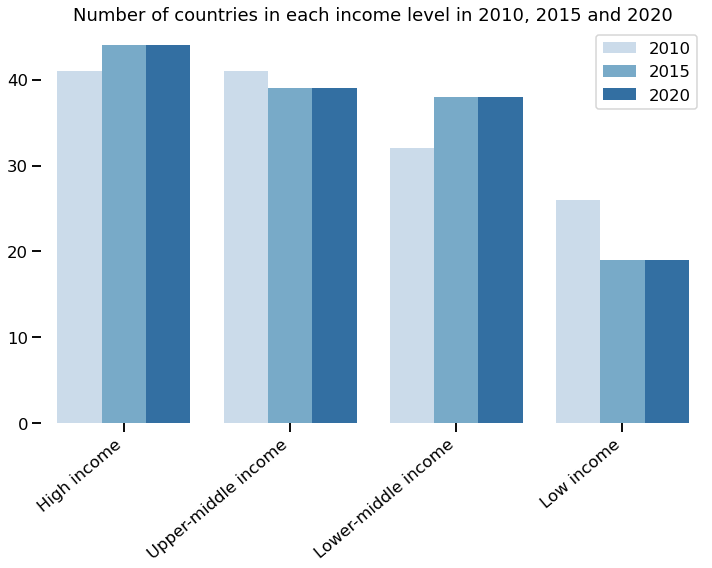

In [214]:
bars(dff, 'Income level', 'Year',
    'Number of countries in each income level in 2010, 2015 and 2020', 'Blues')

* O: Number of countries in the Upper income and lower-middle income levels  increased between 2010 and 2020, while the number of countries in Upper-middle and lower income levels decreased.

> Q: How many countries in each continent belongs to the different economic class?

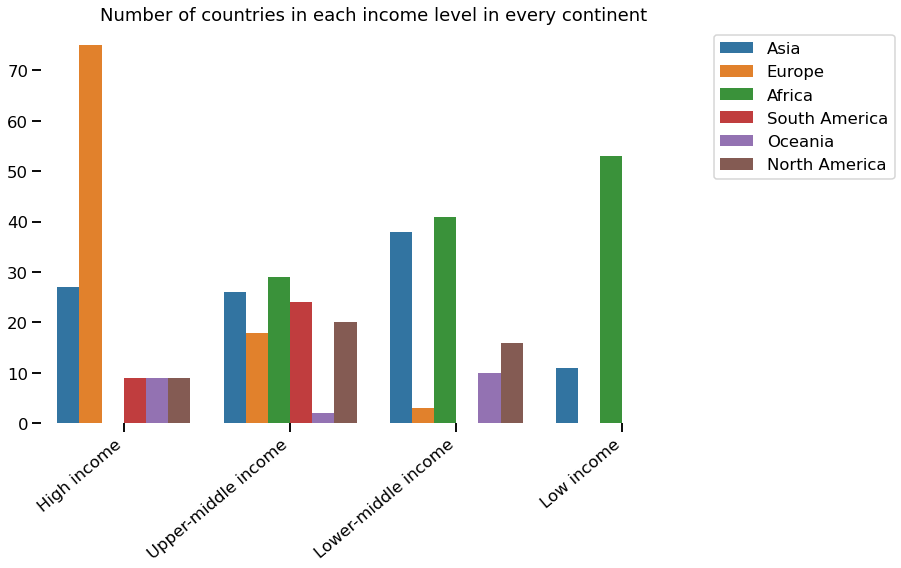

In [171]:
bars(dff, 'Income level', 'continent',
    'Number of countries in each income level in every continent')

* O: Europe has the highest number of `High income` countries, and Africa has the highest number of `lower-middle` and `low` income countries

> Q: How many countries in each subregion belongs to each economic class?

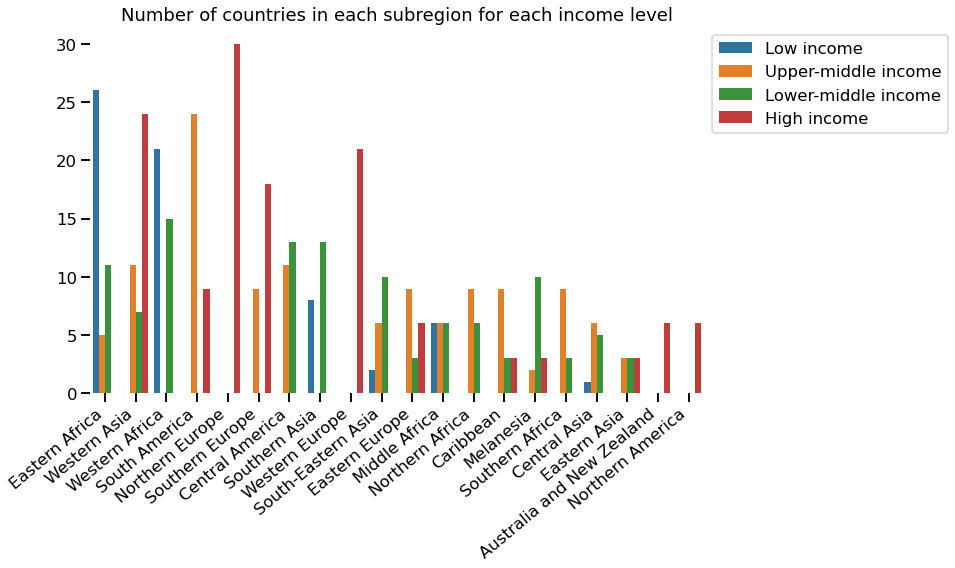

In [172]:
bars(dff, 'subregion', 'Income level',
    'Number of countries in each subregion for each income level')

* O: Most East and West African countries are categoried as `low income` economies. All Northern and Western European countries and Australia and New Zealand are `High income` economies.


> It is obseerved that developed countries have the lowest annual rate of population increase, while the least developed countries have the highest annual rate of population increase.
> Africa has the highest fertility rate with at about 4.5 children per woman followed closely by Oceania, and Europe has the lowest with <1 child per woman. Fertility rate has also dropped globally between 2010 and 2020.
> Infant mortality rate has dropped by ~5 points between 2010 and 2020, and Africa has the highest infant mortality rate.



> The `least developed` nations are predominantly African and Asian countries. Most `developed` countries are European and most `developing` countries are Asian.
> Easter African has more `least developed` countries, than other African regions. Northern Europe, Northern America and Autralia and New Zealand are the only subregions that are considered strictly `developed`.

## Multivariate Exploration

In [181]:
def multi_pplot(df, x, hue, order=None, x_order=None):
    for col in cols:
        plt.figure(figsize=(12, 8))
        sns.pointplot(x=x, y=col, data=df, hue=hue, palette='Paired', hue_order=order, order=x_order);
        plt.xlabel('')
        plt.legend(bbox_to_anchor=(1, 1));
        plt.box(False)
        plt.tight_layout()

> Q: How has the parameter of interest changed over 10 years in different continents?

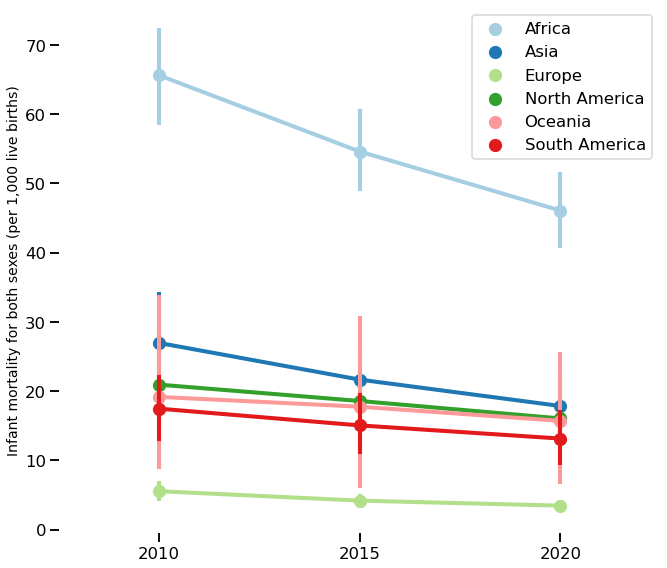

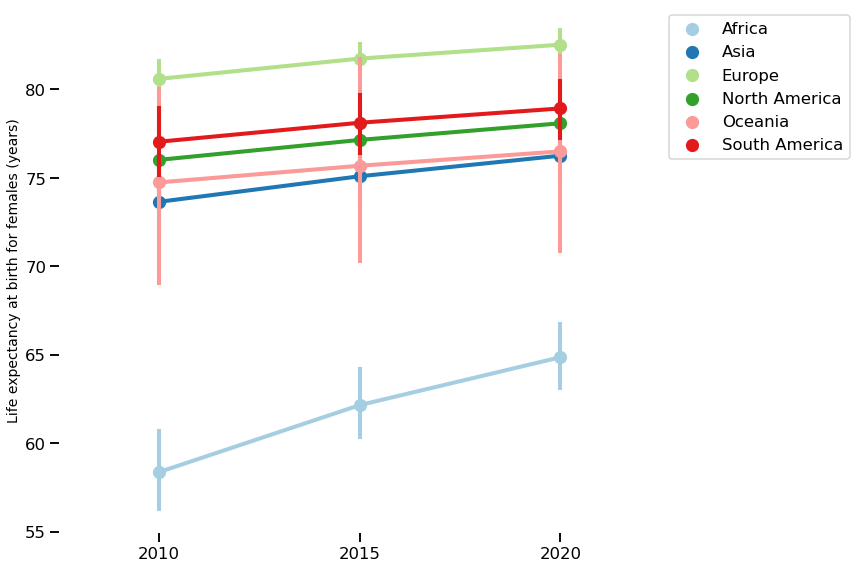

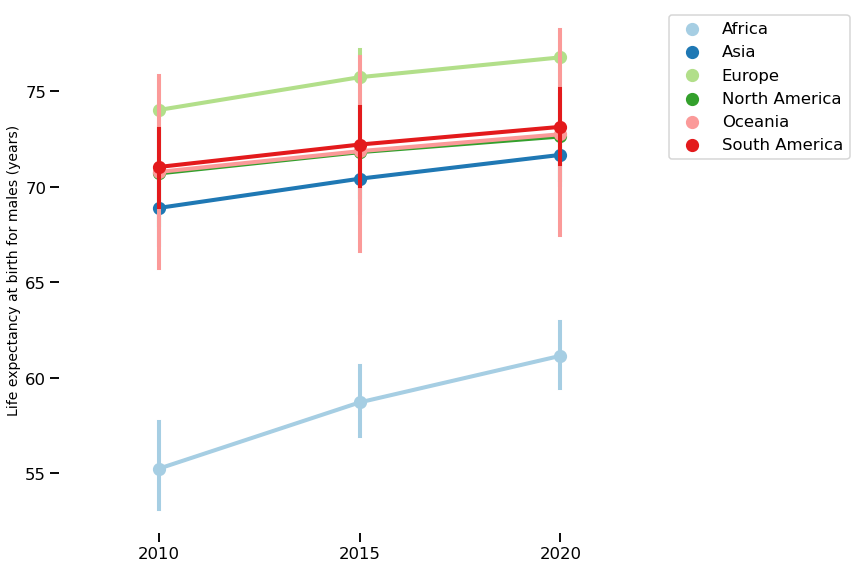

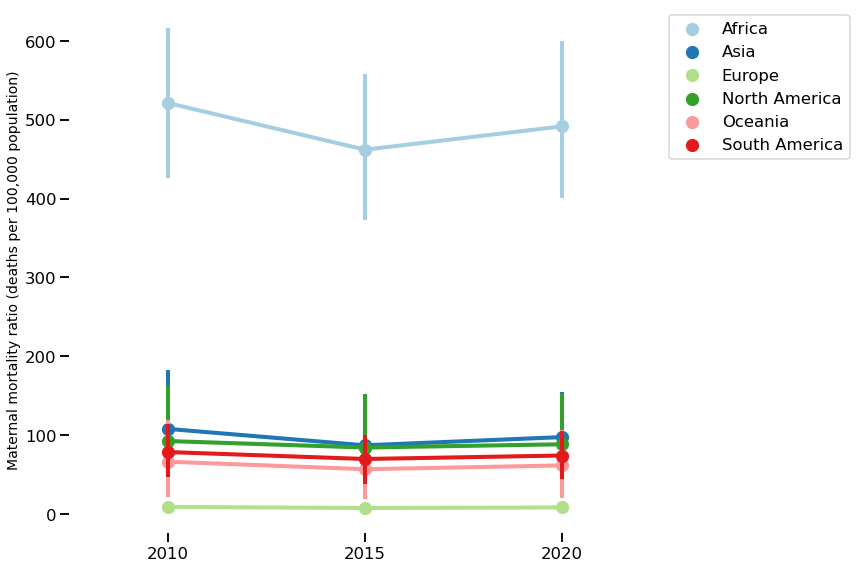

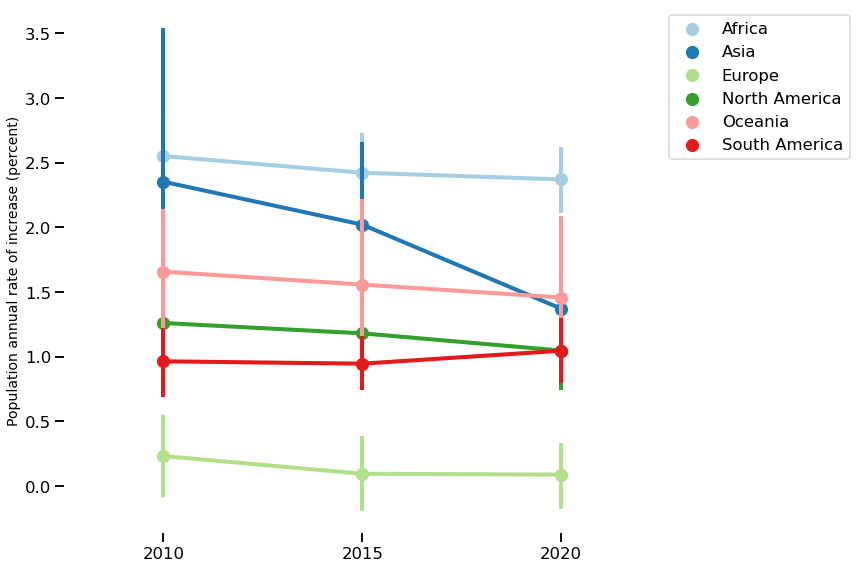

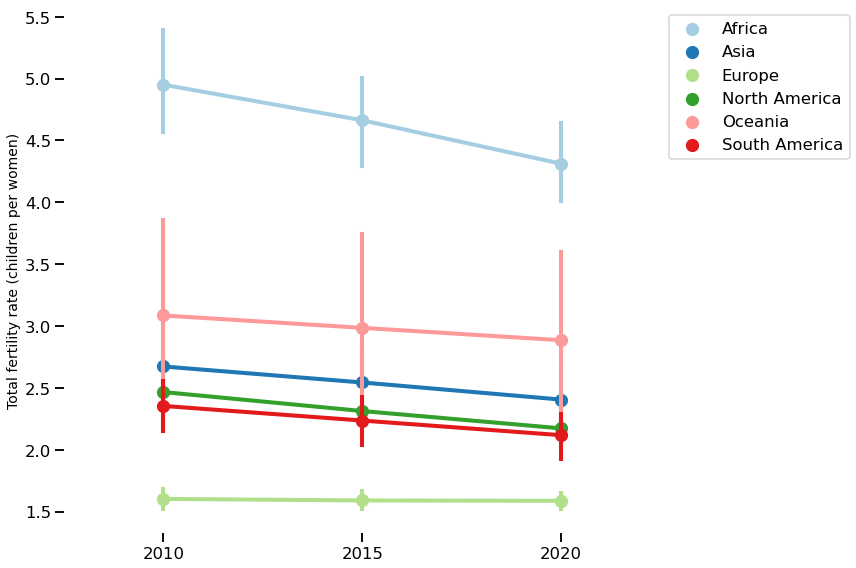

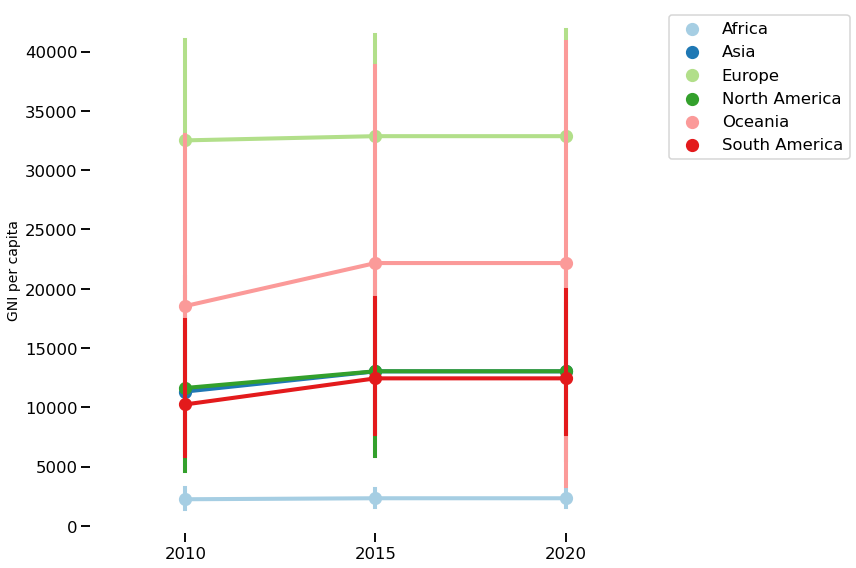

In [182]:
con_order  = dff['continent'].unique()
con_order.sort()

multi_pplot(dff, 'Year', 'continent', con_order)

* O: All continents have seen a slight decrease in their rates of population increase, except South America where the rate of population increase had an uptrend.
* O: Maternal mortality decreased in Africa between 2010 and 2015, but increased between 2015 and 2020. Maternal mortality did not change by much for the other continents.

> Q: How has the parameter of interest changed over 10 years for each income level

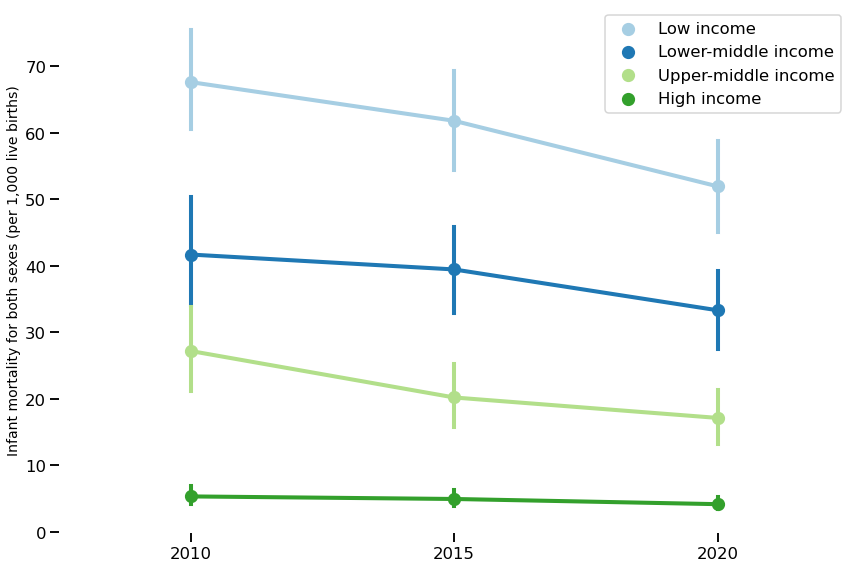

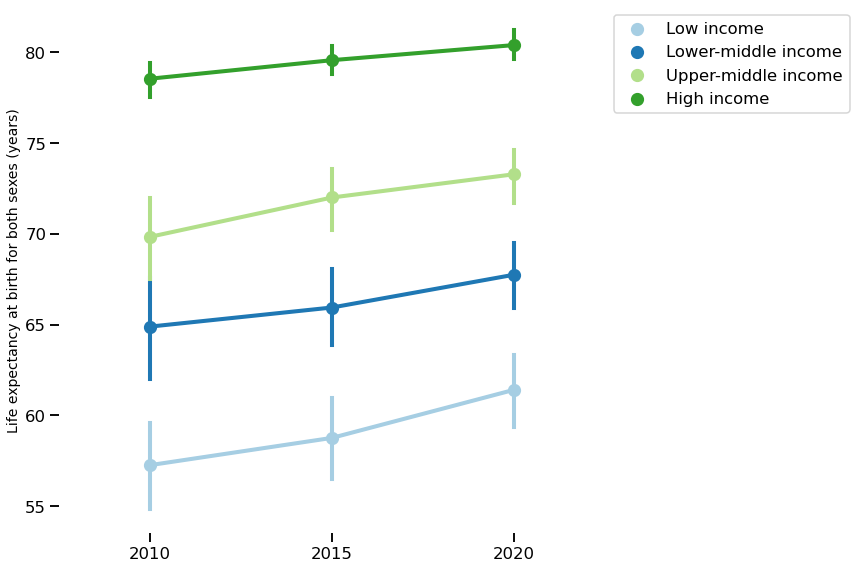

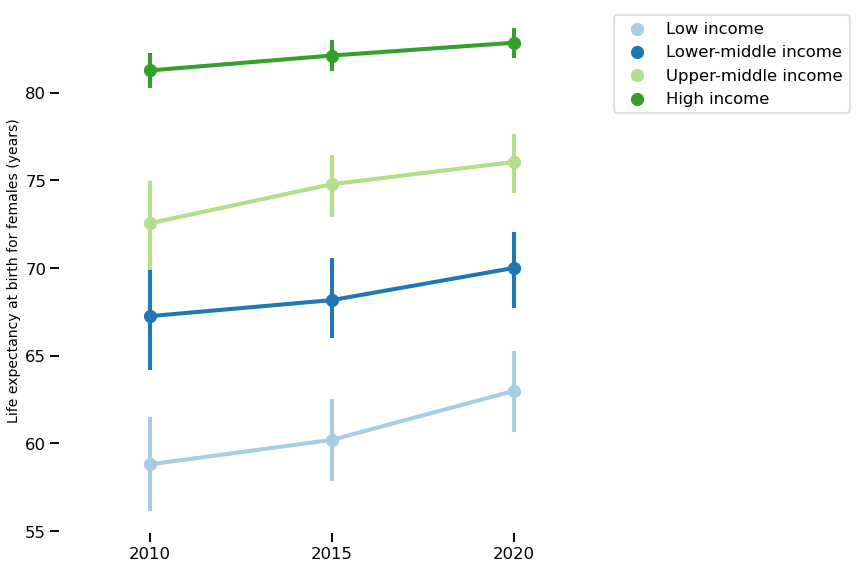

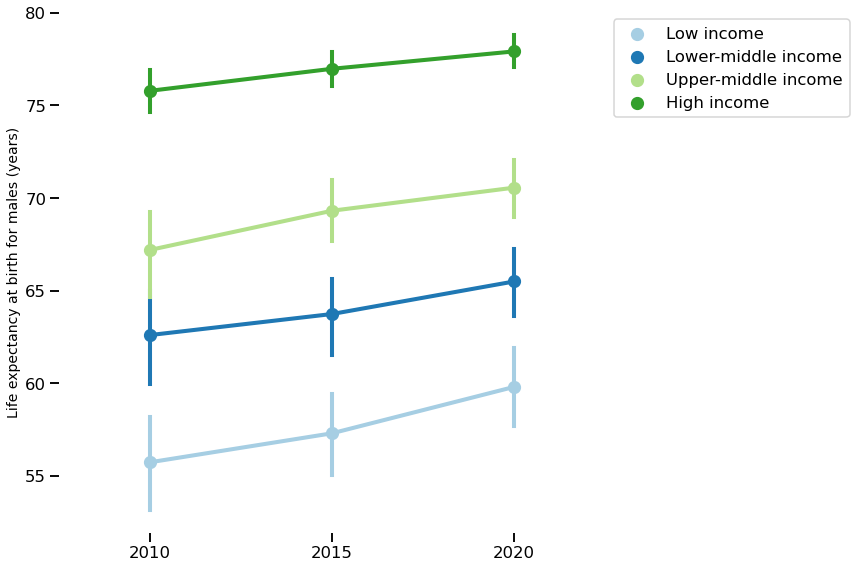

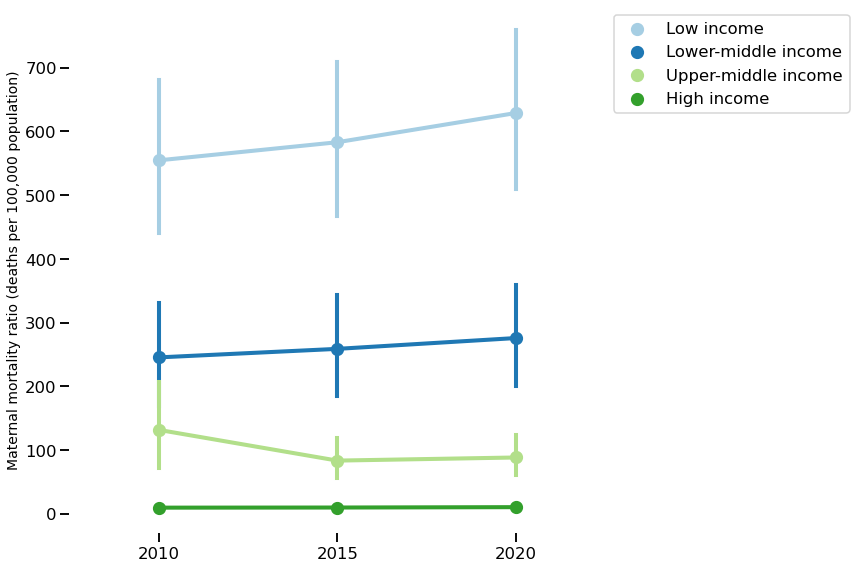

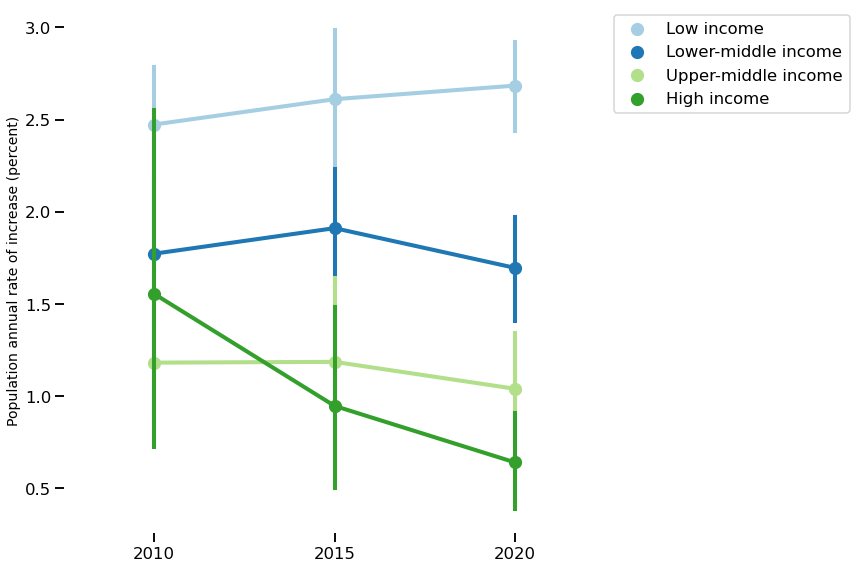

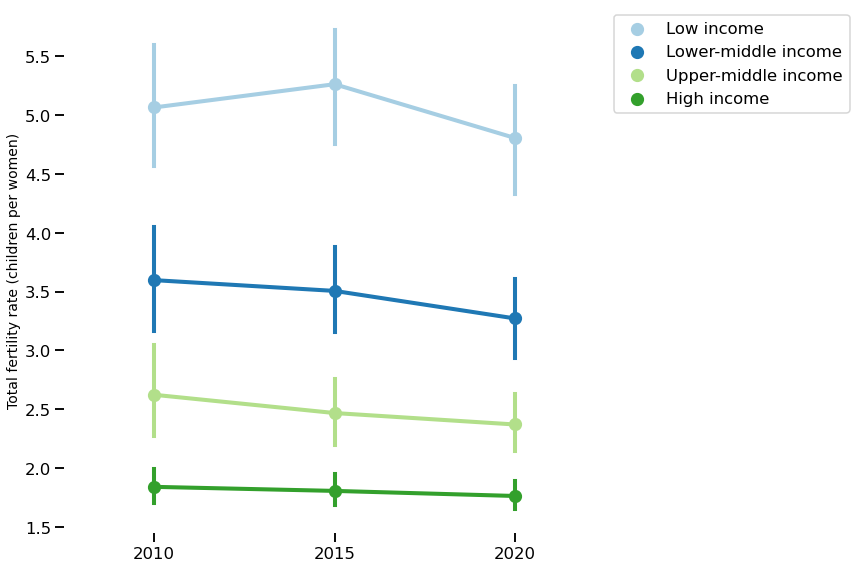

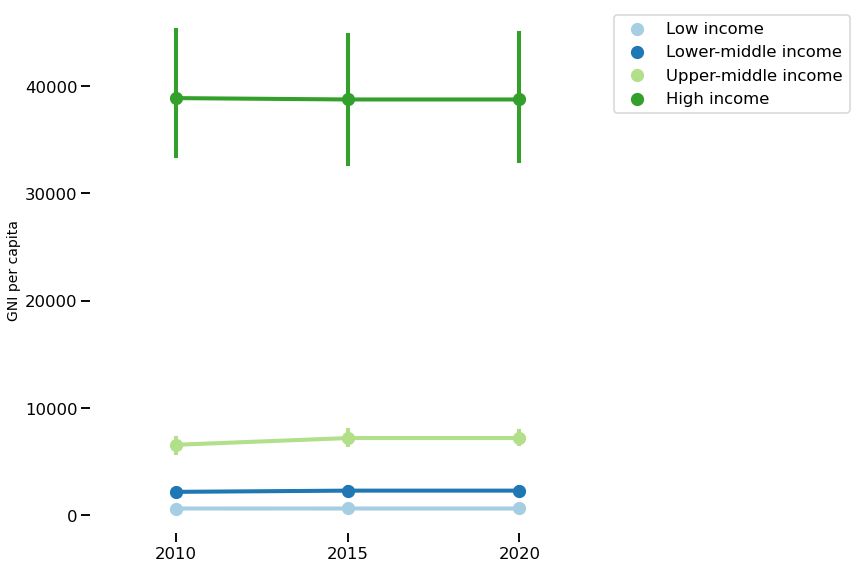

In [183]:
multi_pplot(dff, 'Year', 'Income level',
            order=['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'])

* O: High income countries have an avergae GNI per capita that is about four times as high as those of other continents.
* O: Regardless of income level, fertility rate has dropped over the years. The biggest drop is in low income countries.
* O: The mean population rate of increase has dropped the most in high income countries.

> Q: How different are the average of the variables of interest in different continents in different years

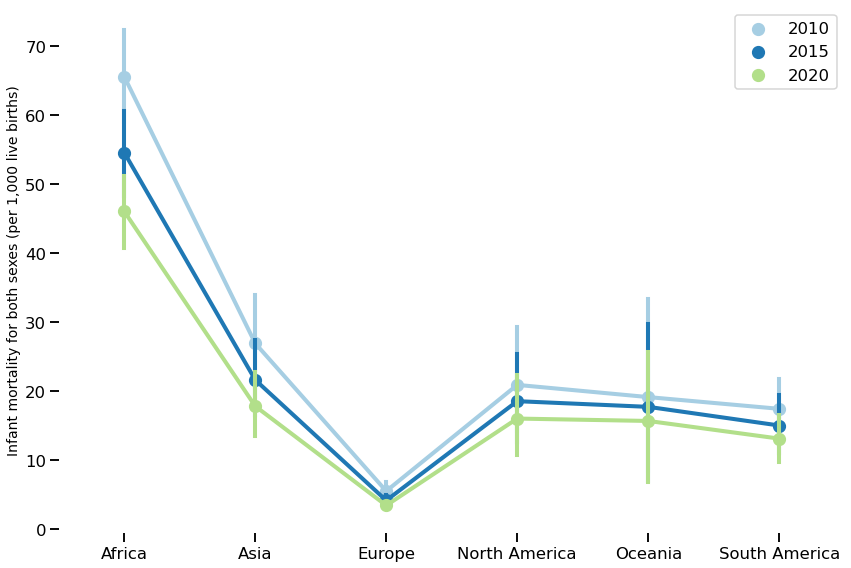

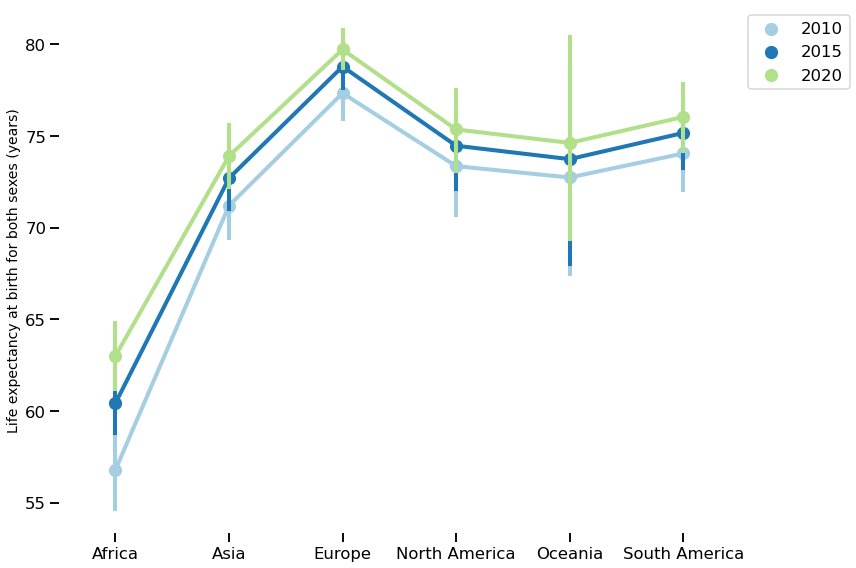

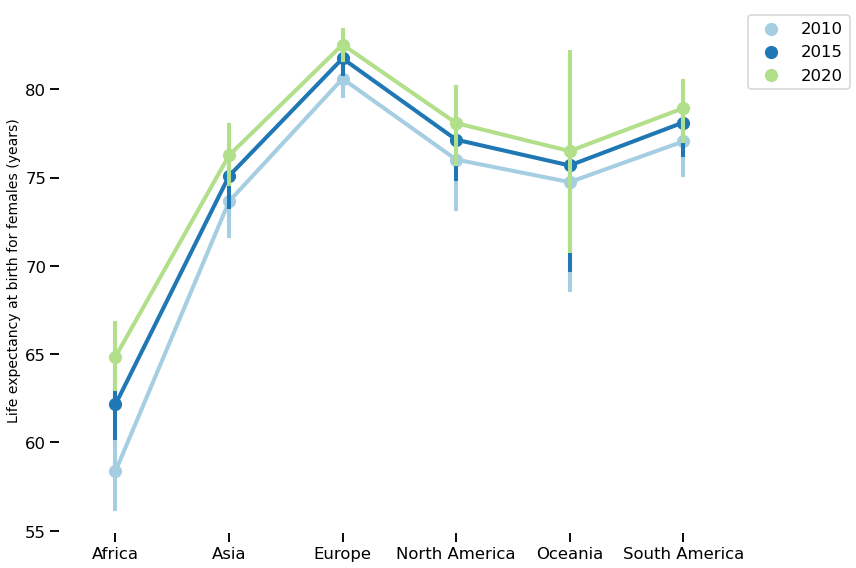

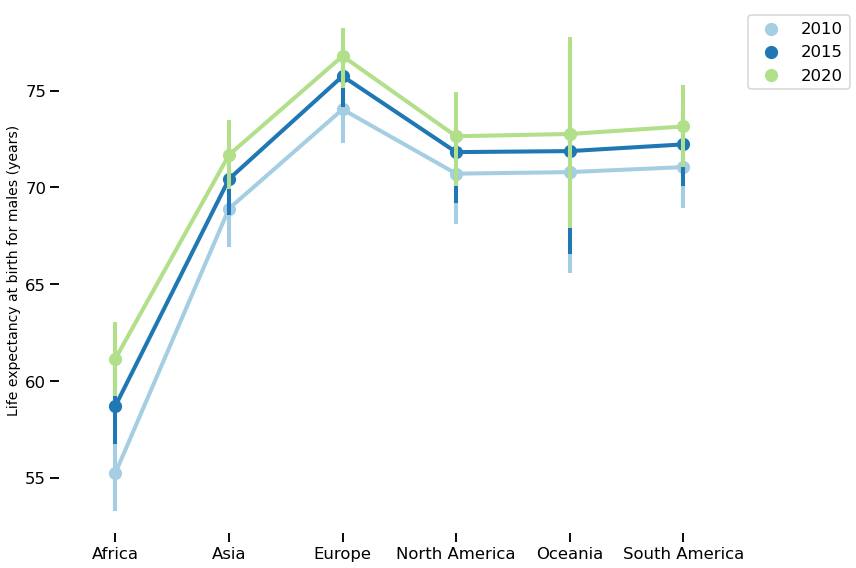

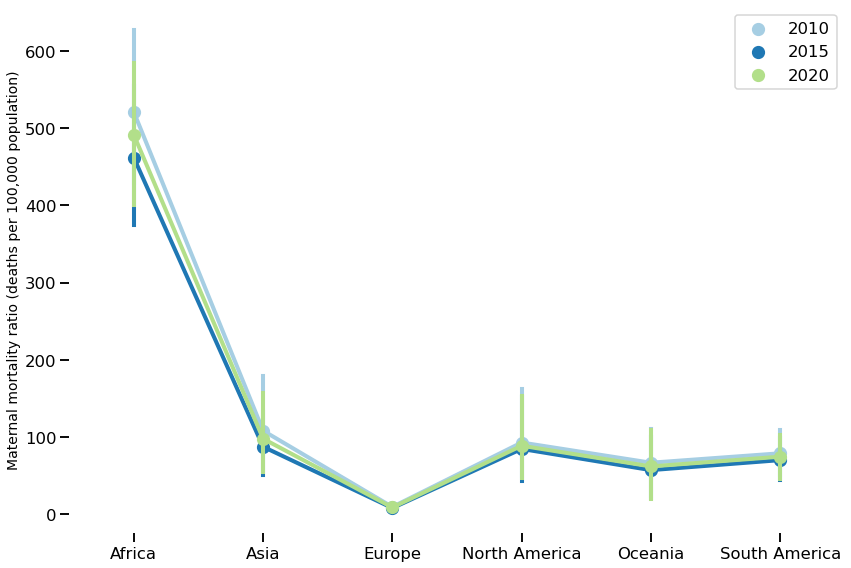

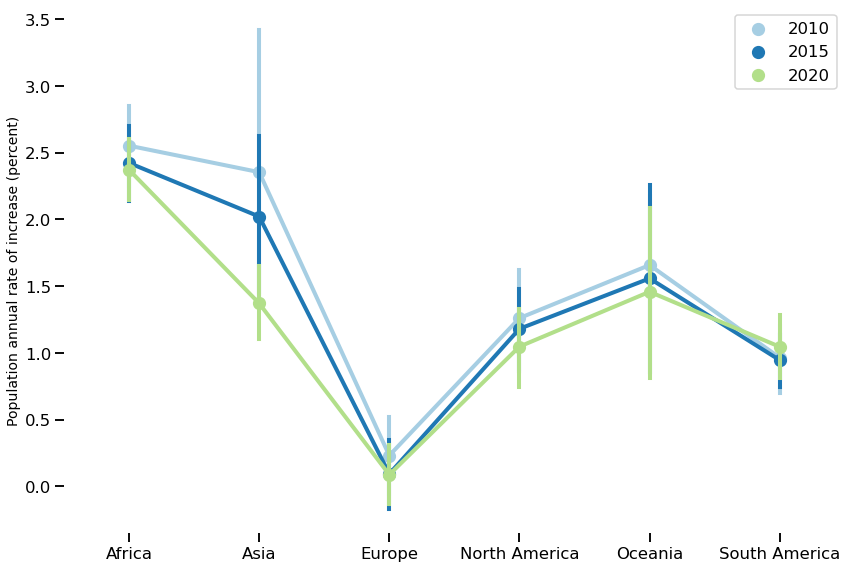

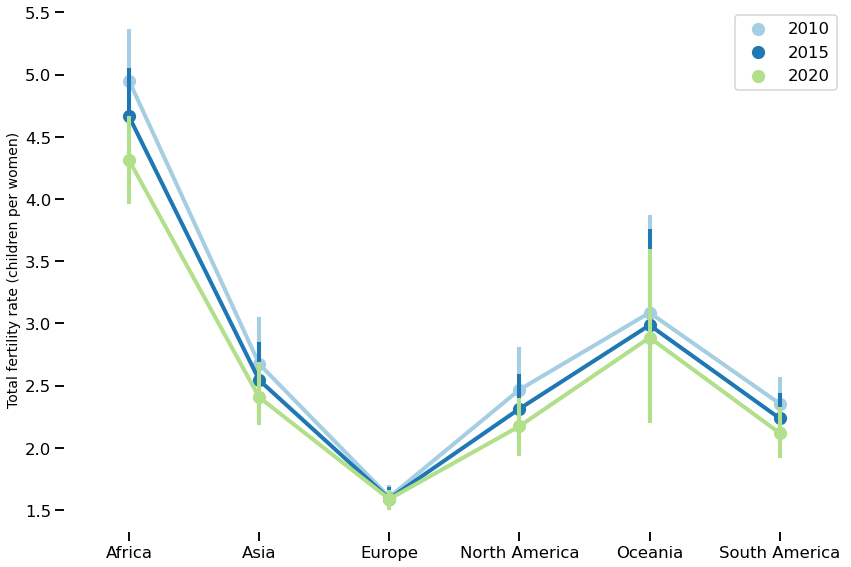

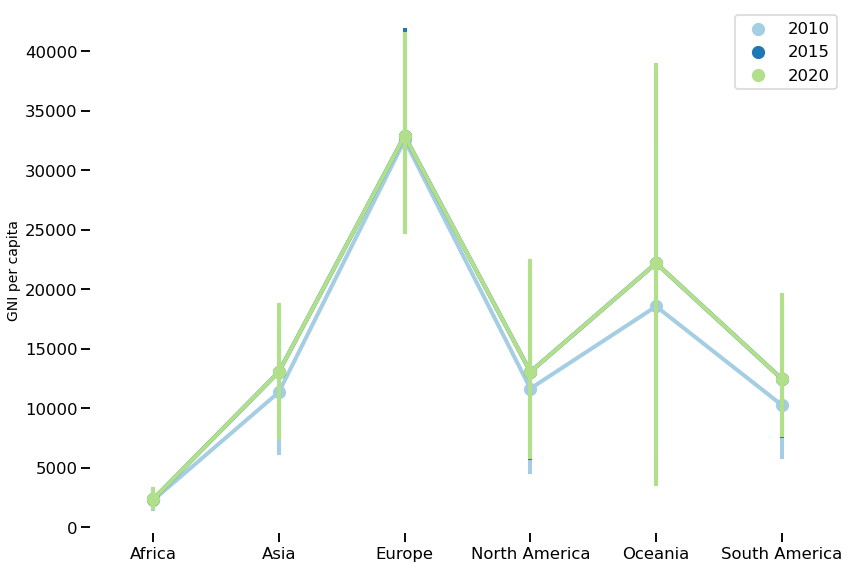

In [184]:
multi_pplot(dff, 'continent', 'Year', x_order=con_order)

* O: All continents have seen a decrease in their rates of infant mortality, with Africa having the most decrease in infant mortality over 10 years, while still having the highest rate of infant mortality.
* O: Maternal mortality improved the least in all continents.
* O: All continents have seen an increase in their life expectancies, with Africa having the most increase in life expectancy over 10 years, while still having the lowest life expectancy.

> Q: Is there any correlation between numerical variables?

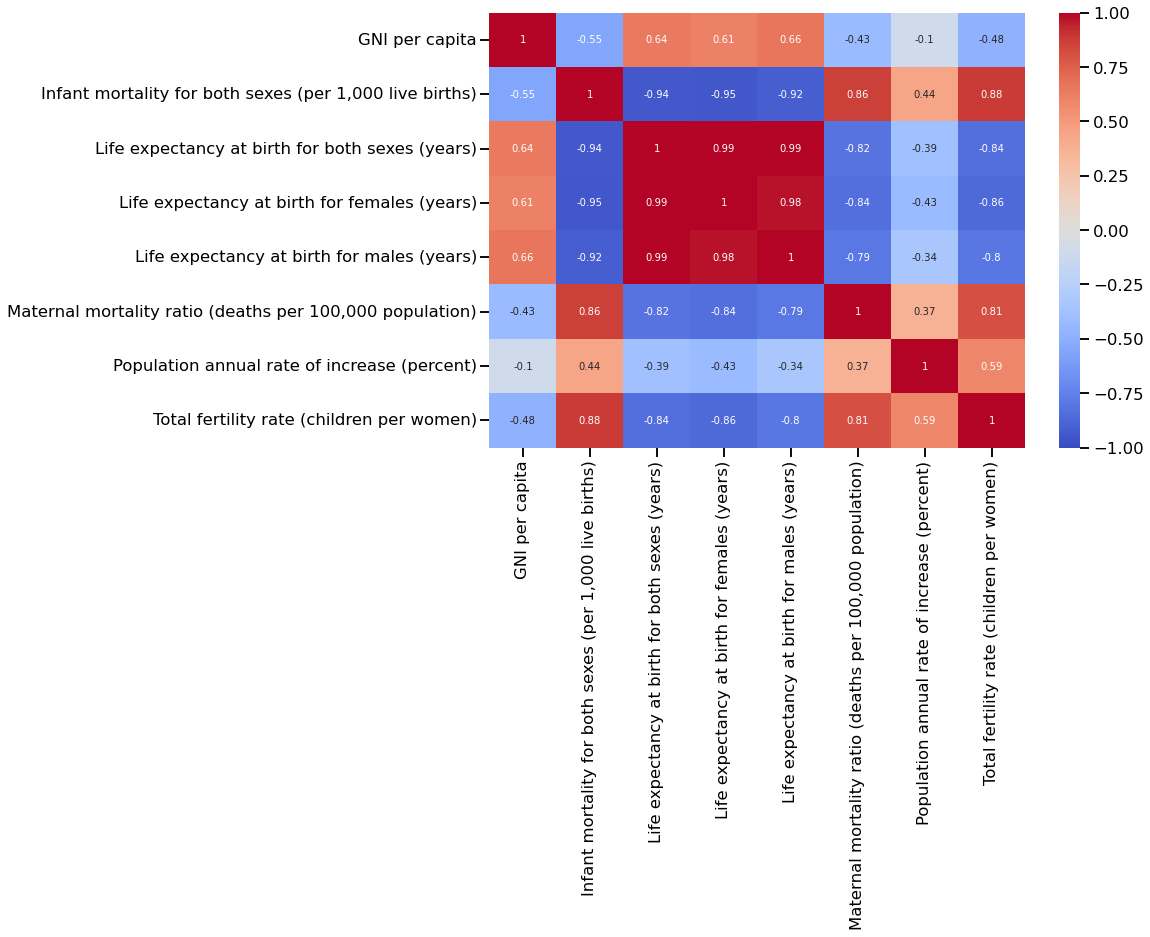

In [220]:
plt.figure(figsize=(12, 8))
plt.box()
sns.heatmap(dff.corr(), cmap='coolwarm', annot=True, center=0, vmin=-1);
plt.xlabel('');
plt.ylabel('');


* O: Some variables have strong and weak positive correlations, while others have negative correlations.

In [197]:
def scatter_plot(df, x, y, hue, order=None, palette=None, title=None):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=x, y=y, data=df, hue=hue, palette=palette, hue_order=order);
    plt.legend(bbox_to_anchor=(1, 1));
    plt.box(False)
    plt.tight_layout()
    plt.title(title)

> Q: What is the relationship between infant mortality and life expectancy in different continents?

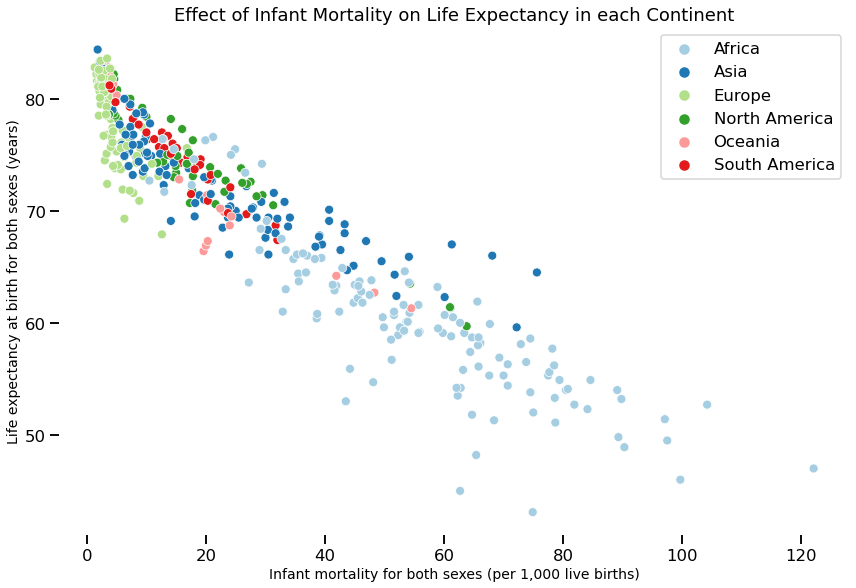

In [199]:
scatter_plot(dff,
            'Infant mortality for both sexes (per 1,000 live births)',
            'Life expectancy at birth for both sexes (years)',
            'continent',
            con_order, 'Paired',
            'Effect of Infant Mortality on Life Expectancy in each Continent')

* O: There is a negative correlation between infant mortality and life expectancy. With Europe and Africa at the opposite ends of the trend.

* Q: What is the relationship between infant mortality and life expectancy in different economies?

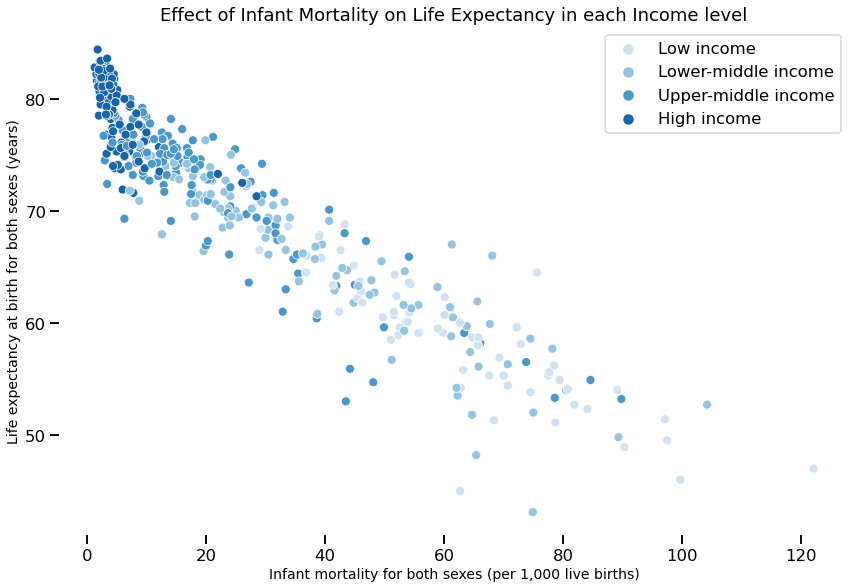

In [200]:
scatter_plot(dff,
            'Infant mortality for both sexes (per 1,000 live births)',
            'Life expectancy at birth for both sexes (years)',
            'Income level',
            ['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'],
             'Blues', 
            'Effect of Infant Mortality on Life Expectancy in each Income level')

* O: There is a negative correlation between infant mortality and life expectancy. With `developed` and `least developed` economies at the opposite ends of the trend.

> Q: What is the relationship between maternal mortality and infant mortality in different income levels?

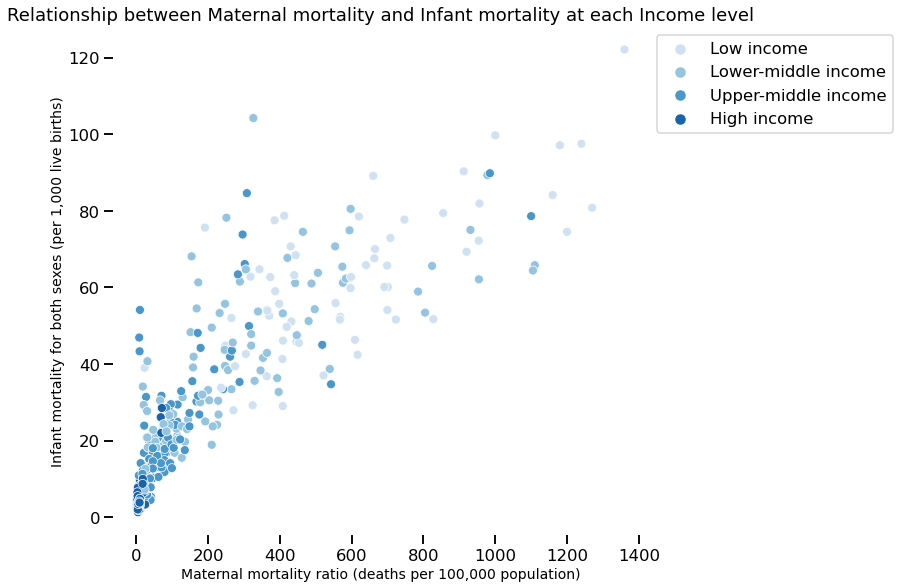

In [202]:
scatter_plot(dff,
            'Maternal mortality ratio (deaths per 100,000 population)',
             'Infant mortality for both sexes (per 1,000 live births)',
            'Income level',
            ['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'],
             'Blues', 
            'Relationship between Maternal mortality and Infant mortality at each Income level')

* O: There is a positive correlation between maternal mortality and infant mortality. With higher maternal and infant mortalities in the `low income` economies.
* O: There is a strong correlation (r=0.87) between maternal mortality and infant mortality rates, with `low income` countries having the highest maternal mortality rate.

> Q: What is the relationship between fertility rate and infant mortality in different income levels

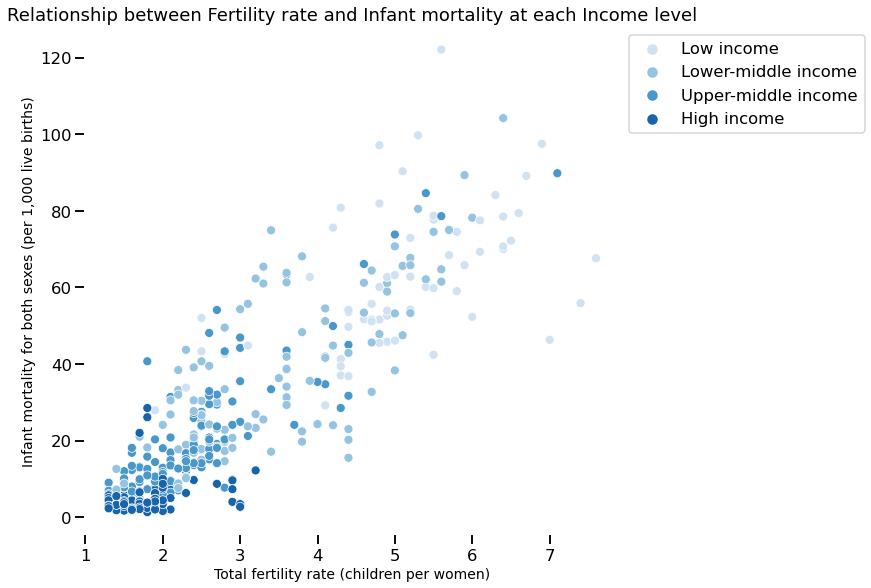

In [204]:
scatter_plot(dff,
            'Total fertility rate (children per women)',
             'Infant mortality for both sexes (per 1,000 live births)',
            'Income level',
            ['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'],
             'Blues', 
            'Relationship between Fertility rate and Infant mortality at each Income level')

* O: There is a positive correlation between fertility rate and infant mortality. With higher fertility and infant mortalities in the `low income` economies.

> Q: What is the relationship between maternal mortality and infant mortality in different continents?

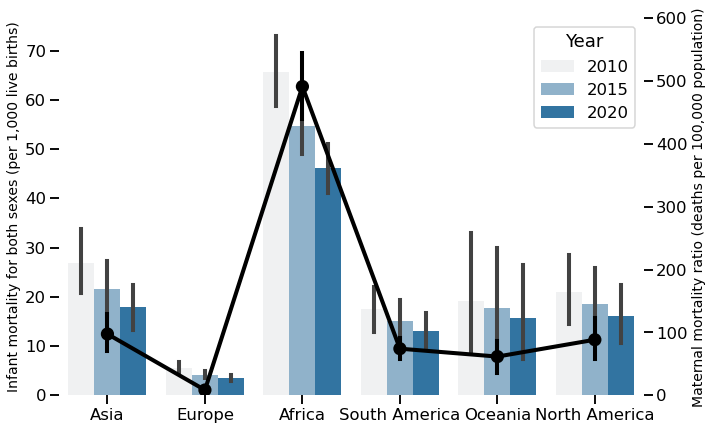

In [374]:


fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='continent', y='Infant mortality for both sexes (per 1,000 live births)', 
    data=dff, ax=ax, color=cp[0], hue='Year')
ax2 = ax.twinx()
sns.pointplot(x='continent', y='Maternal mortality ratio (deaths per 100,000 population)', data=dff, 
    ax=ax2, color='black')
ax2.set_ylim(0, 600)
ax2.set_frame_on(False)
ax.set_frame_on(False)
ax.set_xlabel('')
plt.tight_layout()

* O: There is a positive correlation between maternal mortality and infant mortality. With higher maternal and infant mortalities in the Africa and least mortalities in Europe.
* O: As seen in the previous section, African has the highest infant mortality rate, but there has been a ~ 20 points reduction in infant mortality over 10 years in Africa.
* O: Africa has also seen the biggest reduction in infant mortality compared to other continents, over the same 10 year period.
* O: A similar trend is also observed in the life expectancy. African still haas the lowest life expectancy but has improved by more points compared to the improvement observed in other continents.

In [371]:
'''
Define a function that takes the dataframe, x-axis column name and hue column to make box plots
'''
def box_plots(df, x, hue):
    for col in cols:
        plt.figure(figsize=(12, 8))
        plt.box()
        sns.boxplot(x=x, y=col, data=df, hue=hue, 
                        palette = 'Blues');
        # Infant mortality for both sexes (per 1,000 live births)
        plt.xlabel('')
        plt.tight_layout()

> Q: What has been the relationship between income level and the other variables  over the years?

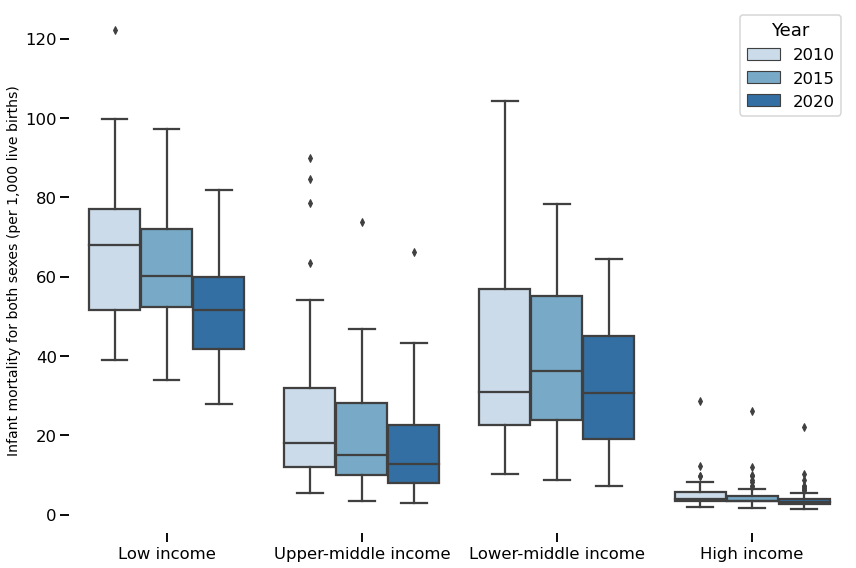

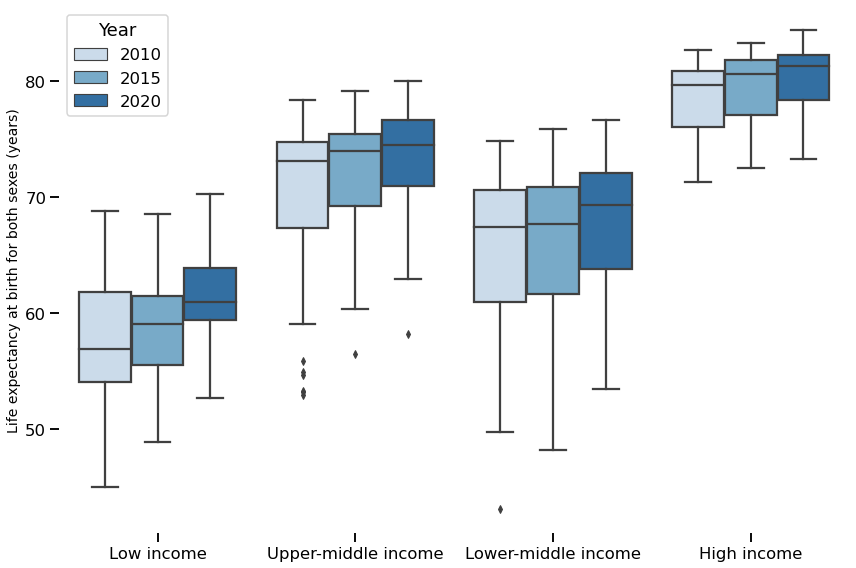

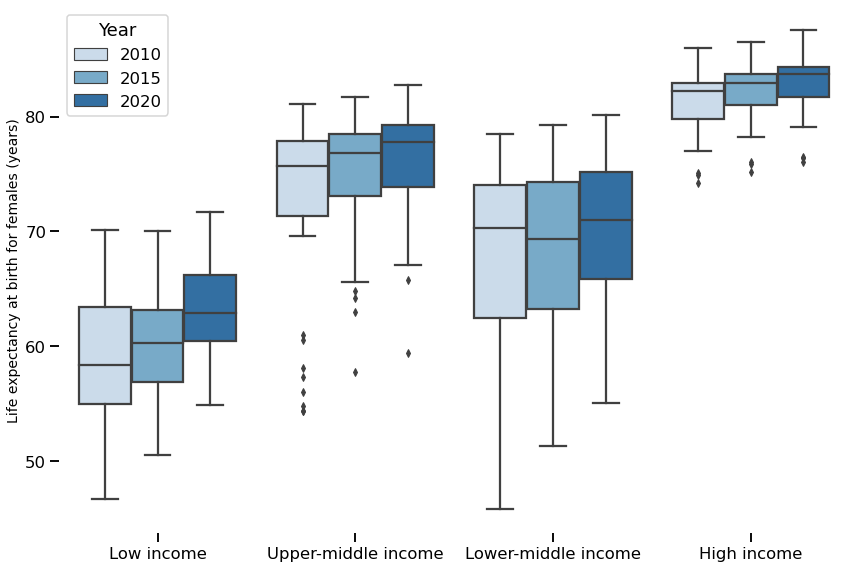

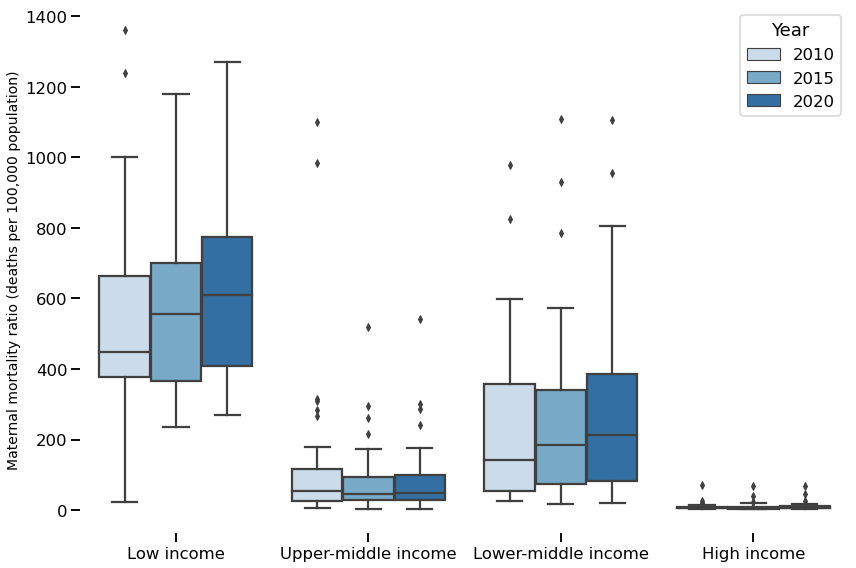

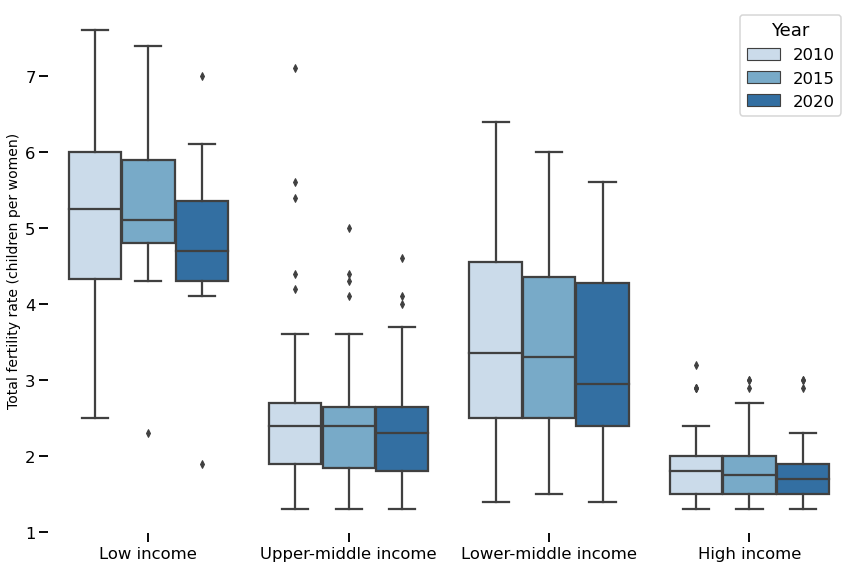

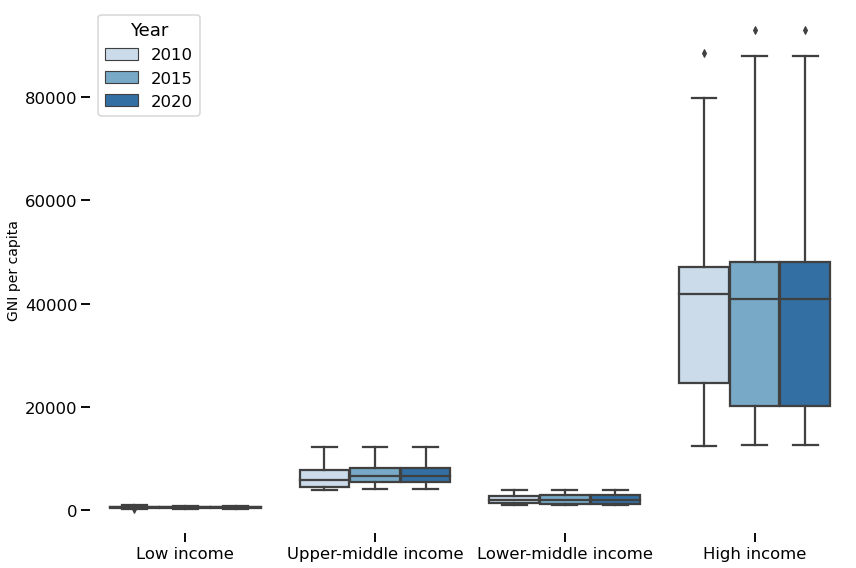

In [309]:
#boxplots to view the relationship between income levels and all variables in all the years
box_plots(dff, 'Income level', 'Year')

* O: In the `low income` regions, maternal mortality is at the highest and the lowest in the `high income` regions. While there has been a decrease in maternal mortality in `low income` economies, it is not a significant decrease.
* O: In the `low income` regions, infant mortality is at the highest and the lowest in the `high income` regions.
* O: In the `low income` regions, life expectancy is at the lowest and the highest in the `high income` regions.

In [216]:
'''
Define a fnction that takes the dataframe, the x-axis column, size column and other optional arguments
for making scatter plots to view relationship between two and more variables.
'''

def scatter_duoplot(df, x, hue1=None, hue2= None, order1=None, order2=None):
    for col in cols:
        fig, ax = plt.subplots(1,2,figsize=(20, 10))
        sns.scatterplot(x=x, y=col, data=df,
                      hue=hue1, palette='Paired', 
                      hue_order=order1, 
                      ax=ax[0],  #size_order=[40, 100, 300, 600]
                      );
        sns.scatterplot(x=x, y=col, data=df,
                      hue=hue2, palette='Paired', 
                      hue_order=order2, 
                      ax=ax[1],  #size_order=[40, 100, 300, 600]
                      );
        ax[0].set_frame_on(False)
        ax[1].set_frame_on(False)

> Q: What has been the relationship between GNI per capita and other variables in differents regions and income levels

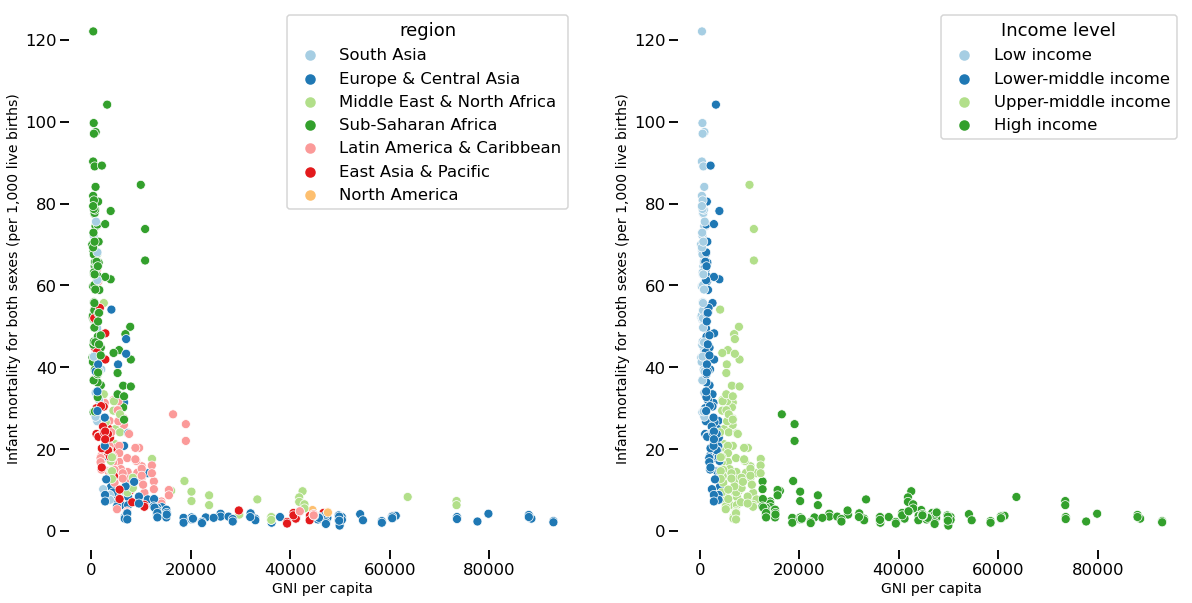

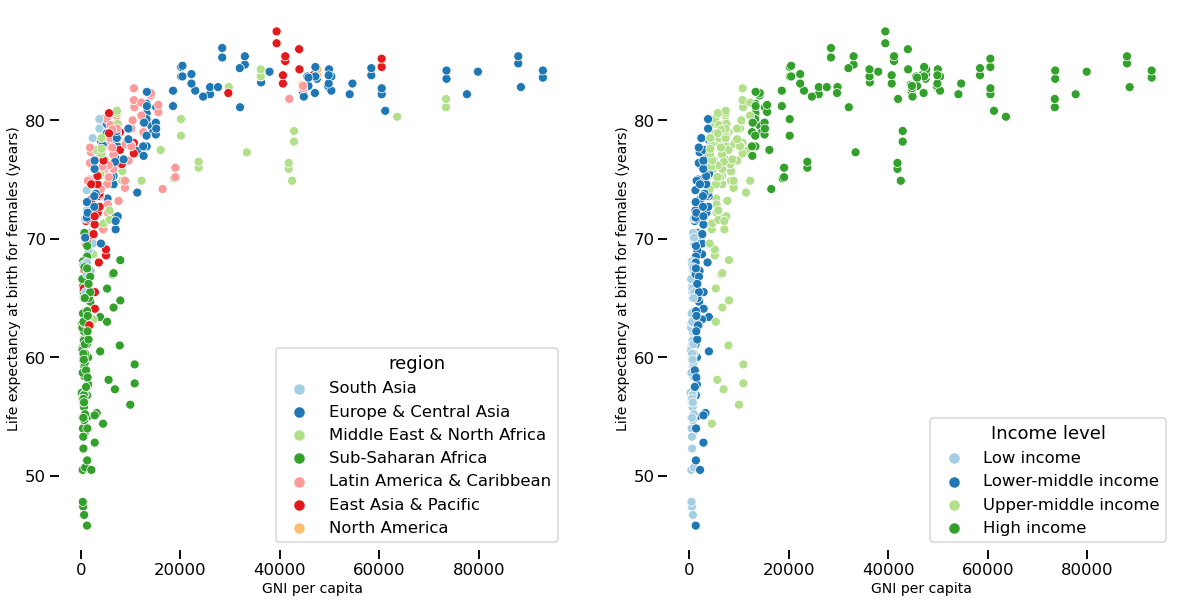

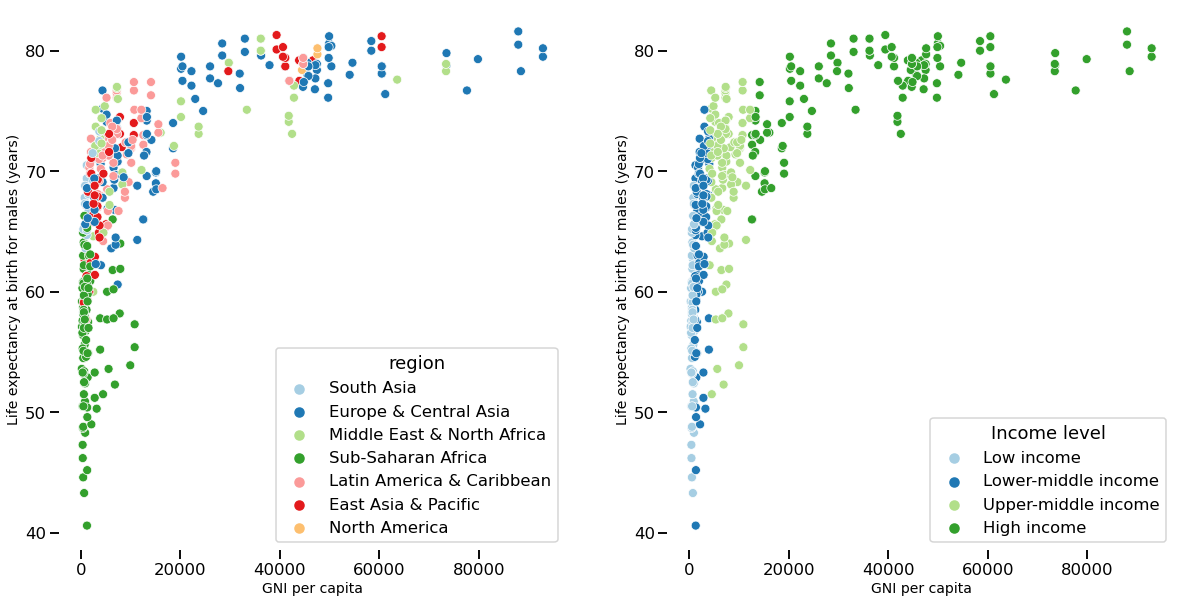

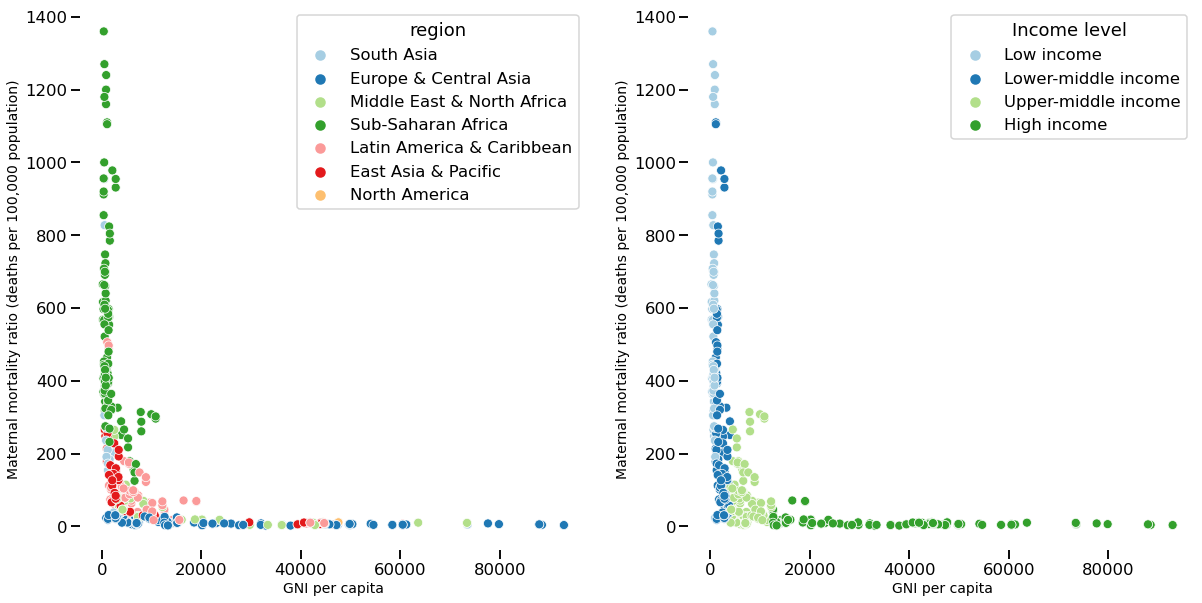

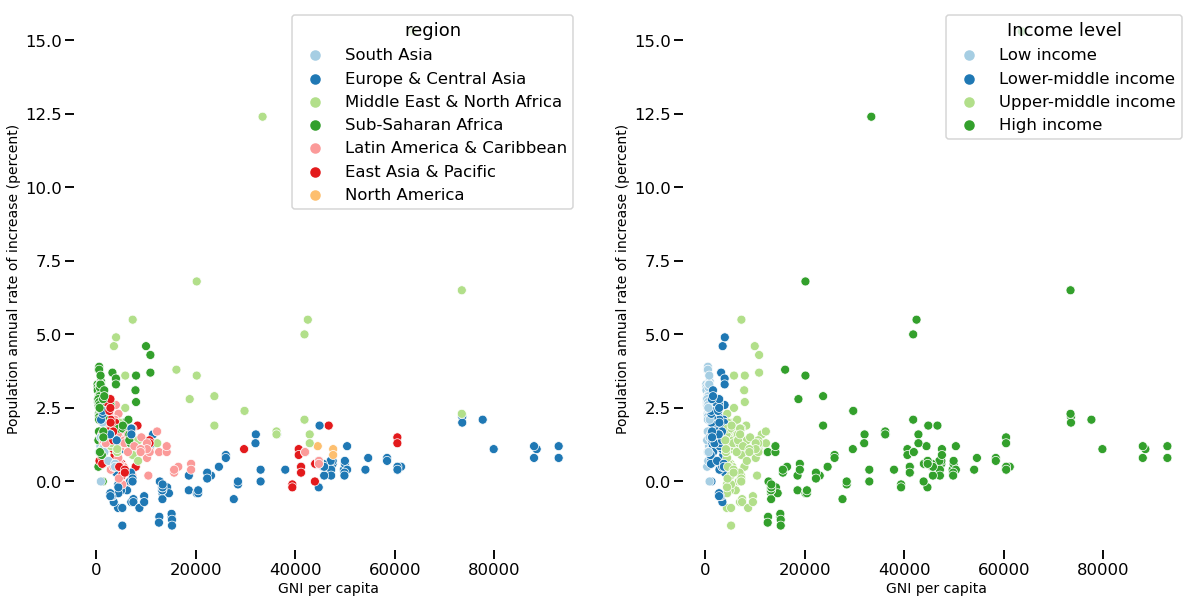

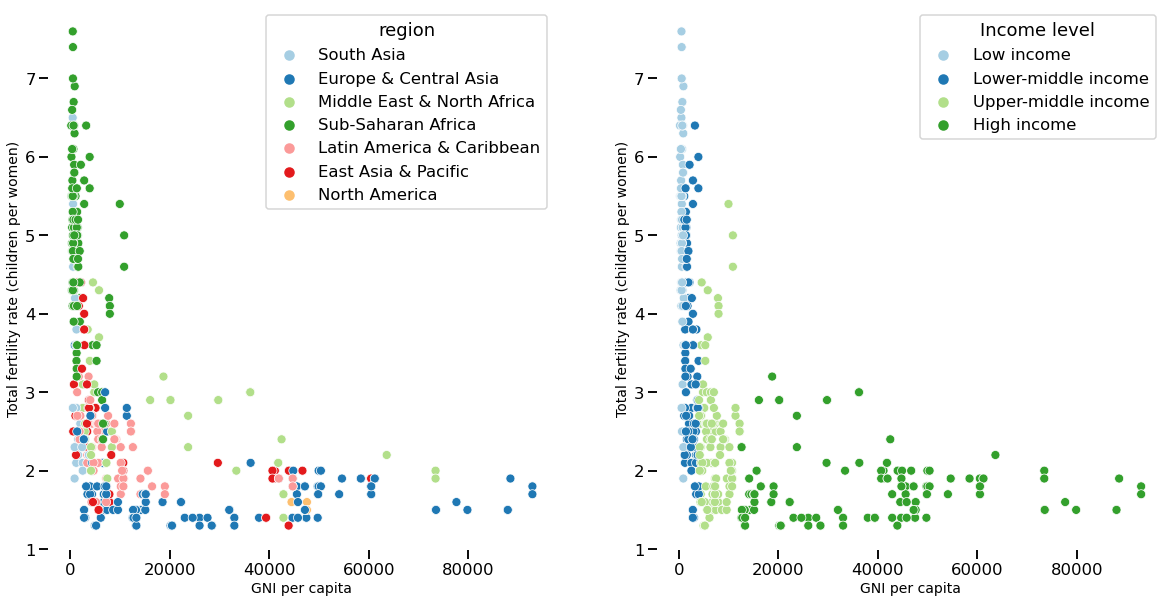

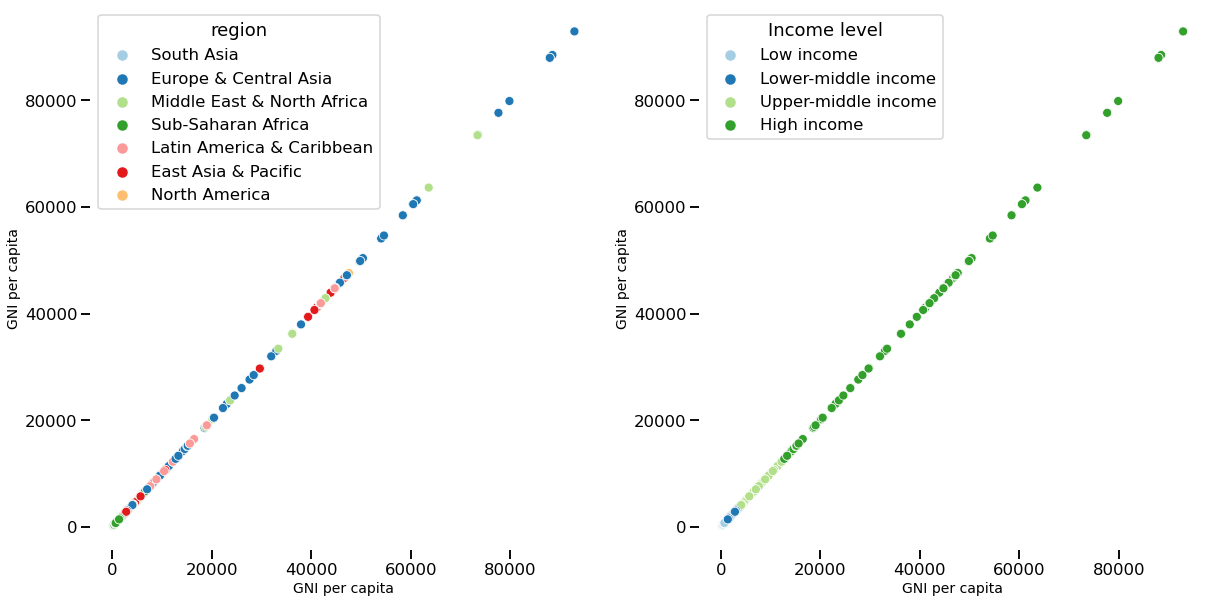

In [217]:
scatter_duoplot(dff, 
             'GNI per capita', 
             hue1='region', 
             hue2='Income level',
            order2 = ['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'])

* O: In the `low income` countries, life expectancy is at the lowest and the highest in the `high income` countries. `low income` and `lower-middle income` economies have similar levels of infant mortality, maternal mortality and fertility rate.
* O: The GNI per capita shows no effect on the population growth per year.

> Q: Does fertility rate have any impact of the growth of the population

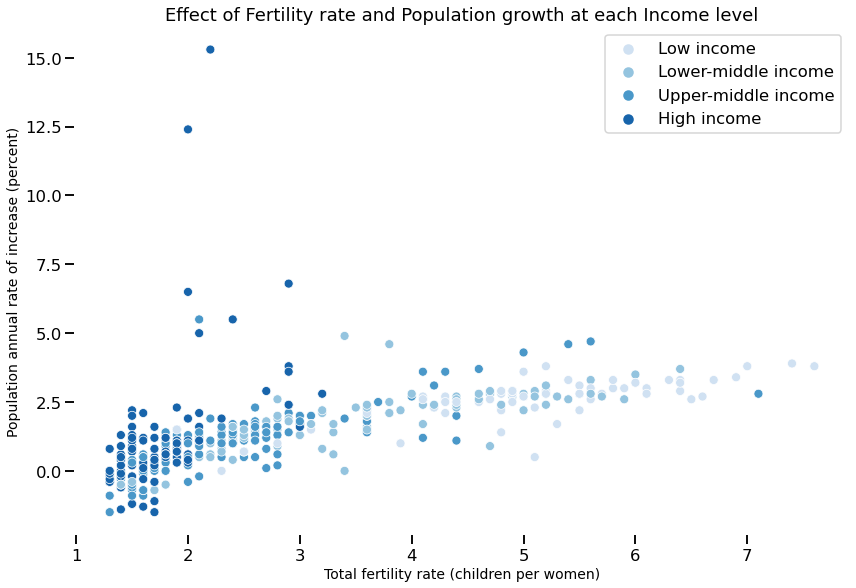

In [209]:
scatter_plot(dff,
            'Total fertility rate (children per women)',
             'Population annual rate of increase (percent)',
            'Income level',
            ['Low income', 'Lower-middle income', 'Upper-middle income', 'High income'],
             'Blues', 
            'Effect of Fertility rate and Population growth at each Income level')

* O: It was surprising to see that fertility rate has a weak effect on the population growth.

## Conclusions

> Sequel to exploring this dataset, we can conclude the following;
* More countries are categorized as `High income `and the least number of countries as `low income`.
* More countries have lower infant and maternal mortality rate, population increase rate and higher life expectancy.
* Developed countries have the lowest rate of population growth, which appears to be related to the low fertility rate in developed countries. Africa has the highest fertility rate and annual population increase rate and is predominantly a `low income` economy.
* There has been a drop in the annual rate of population increase between 2010 and 2020, with Asia experiencing the most reduction in rate of population increase and South America has seen an uptrend in the rate of population increase.
* There is a strong correlation between maternal mortality and infant mortality, indicating that a child whose mother dies is likely to survive, especially in least developed economies like Africa.
* While the African continent and `low income` economies show poor data in terms of mortalities and life expectancies, they also have the highest improvements in these aspects. This is an indication of improved health and healthcare.
* The high fertility rate in the African continent and 'least developed economies, indicates that the population is younger which can be beneficial towards improvement the economy and overall livelihood and health of its citizens.


> Further Work
* Explore in more details relating to subregions, to understand the changes on a smaller scale
* Explore applying this data for forecasting future trends
* Is it possible to predict the economic class of a country using this dataset?

